In [16]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, 
    coco_detection_yolo_format_val
)
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm
 
import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random



In [17]:
import json
import os


# Ensure the label directory exists
def create_labels(coco_json_path,label_dir):
    os.makedirs(label_dir, exist_ok=True)
    os.makedirs(label_dir+"/data/",exist_ok=True)
    # Load COCO JSON annotations
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    # Function to convert COCO bounding box to YOLO format
    def coco_to_yolo(bbox, img_width, img_height):
        x_center = bbox[0] + bbox[2] / 2
        y_center = bbox[1] + bbox[3] / 2
        width = bbox[2]
        height = bbox[3]
        # Normalize coordinates
        return x_center / img_width, y_center / img_height, width / img_width, height / img_height

    # Create a dictionary to map image IDs to file names
    image_id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}
    print(image_id_to_filename)
    # Create a dictionary to map category IDs to their YOLO class ID (index)
    category_id_to_class_id = {cat['id']: idx for idx, cat in enumerate(coco_data['categories'])}

    # Process annotations
    for annotation in coco_data['annotations']:
        image_id = annotation['image_id']
        category_id = annotation['category_id']
        bbox = annotation['bbox']
        
        # Find corresponding image filename and dimensions
        image_filename = image_id_to_filename[image_id]
        img_width = next(img['width'] for img in coco_data['images'] if img['id'] == image_id)
        img_height = next(img['height'] for img in coco_data['images'] if img['id'] == image_id)
        
        # Convert COCO bbox format to YOLO format
        yolo_bbox = coco_to_yolo(bbox, img_width, img_height)
        
        # Get YOLO class ID
        class_id = category_id_to_class_id[category_id]
        
        # Create label file path
        label_file_path = os.path.join(label_dir, os.path.splitext(image_filename)[0] + '.txt')
        
        # Append annotation to label file
        with open(label_file_path, 'a') as label_file:
            label_file.write(f"{class_id} {' '.join(map(str, yolo_bbox))}\n")

    print("Label files creation completed.")


In [18]:
# Path to your COCO JSON file
coco_json_path = './FLIR_ADAS_v2/images_thermal_train/coco.json'
# Directory where you want to save the label files
label_dir = './FLIR_ADAS_v2/images_thermal_train/labels'
create_labels(coco_json_path,label_dir)
# Path to your COCO JSON file
coco_json_path = './FLIR_ADAS_v2/images_thermal_val/coco.json'
# Directory where you want to save the label files
label_dir = './FLIR_ADAS_v2/images_thermal_val/labels'
create_labels(coco_json_path,label_dir)
# Path to your COCO JSON file
coco_json_path = './FLIR_ADAS_v2/video_thermal_test/coco.json'
# Directory where you want to save the label files
label_dir = './FLIR_ADAS_v2/video_thermal_test/labels'
create_labels(coco_json_path,label_dir)


{0: 'data/video-GzdKTLbkG5F7gAunM-frame-000108-QHZmA4QTZCnzBG3HZ.jpg', 1: 'data/video-GzdKTLbkG5F7gAunM-frame-000123-zT9WiGpogNTW2duPu.jpg', 2: 'data/video-GzdKTLbkG5F7gAunM-frame-000138-hGJXmoECsAKraavzR.jpg', 3: 'data/video-GzdKTLbkG5F7gAunM-frame-000153-CLf3aejSKSCNt94Aw.jpg', 4: 'data/video-GzdKTLbkG5F7gAunM-frame-000168-T6ecK2ACpL8zQCKwL.jpg', 5: 'data/video-GzdKTLbkG5F7gAunM-frame-000284-v68F7QyxkFbbGqgzg.jpg', 6: 'data/video-GzdKTLbkG5F7gAunM-frame-000299-ZteJGSdeWHa5yH2vx.jpg', 7: 'data/video-GzdKTLbkG5F7gAunM-frame-000314-eX5pi3pcXMkXDivrC.jpg', 8: 'data/video-GzdKTLbkG5F7gAunM-frame-000329-CvNDA6nRRHaphYaCg.jpg', 9: 'data/video-GzdKTLbkG5F7gAunM-frame-000344-TM4zrDbGGHafGD5ew.jpg', 10: 'data/video-GzdKTLbkG5F7gAunM-frame-000359-FZJ62yuucEZeTisfB.jpg', 11: 'data/video-GzdKTLbkG5F7gAunM-frame-000374-vkJ8c96xNDdEwqAEZ.jpg', 12: 'data/video-GzdKTLbkG5F7gAunM-frame-000389-xNBEaFoPwygS6ykzS.jpg', 13: 'data/video-GzdKTLbkG5F7gAunM-frame-000404-e8cCWh4sF25XyHuwz.jpg', 14: 'data/video

In [19]:
ROOT_DIR = './FLIR_ADAS_v2'
train_imgs_dir = 'images_thermal_train/data'
train_labels_dir = 'images_thermal_train/labels/data'
val_imgs_dir = 'images_thermal_val/data'
val_labels_dir = 'images_thermal_val/labels/data'
test_imgs_dir = 'images_thermal_test/data'
test_labels_dir = 'images_thermal_test/labels/data'
classes = ['Person', 'Car', 'Bicycle', 'OtherVechicle', 'DontCare']
 
dataset_params = {
    'data_dir':ROOT_DIR,
    'train_images_dir':train_imgs_dir,
    'train_labels_dir':train_labels_dir,
    'val_images_dir':val_imgs_dir,
    'val_labels_dir':val_labels_dir,
    'test_images_dir':test_imgs_dir,
    'test_labels_dir':test_labels_dir,
    'classes':classes 
}



In [20]:
# Global parameters.
EPOCHS = 50
BATCH_SIZE = 16
WORKERS = 8

In [21]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)
 
val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

[2024-02-24 15:22:15] WARNING - yolo_format_detection.py - 264 images are note associated to any label file
[2024-02-24 15:22:15] WARNING - yolo_format_detection.py - As a consequence, 10478/10742 images and 10478/10478 label files will be used.
[2024-02-24 15:22:15] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.


Label files creation completed.


Indexing dataset annotations: 100%|██████████| 10478/10478 [00:01<00:00, 6273.19it/s]
[2024-02-24 15:22:17] WARNING - detection_dataset.py - Found 127758 invalid bbox that were ignored. For more information, please set `show_all_warnings=True`.
[2024-02-24 15:22:17] WARNING - yolo_format_detection.py - 16 images are note associated to any label file
[2024-02-24 15:22:17] WARNING - yolo_format_detection.py - As a consequence, 1128/1144 images and 1128/1128 label files will be used.
[2024-02-24 15:22:17] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 1128/1128 [00:00<00:00, 8161.88it/s]
[2024-02-24 15:22:17] WARNING - detection_dataset.py - Found 9736 invalid bbox that were ignored. For more information, please set `show_all_warnings=True`.


In [22]:
train_data.dataset.transforms

In [23]:
train_data.dataset.transforms.pop(2)




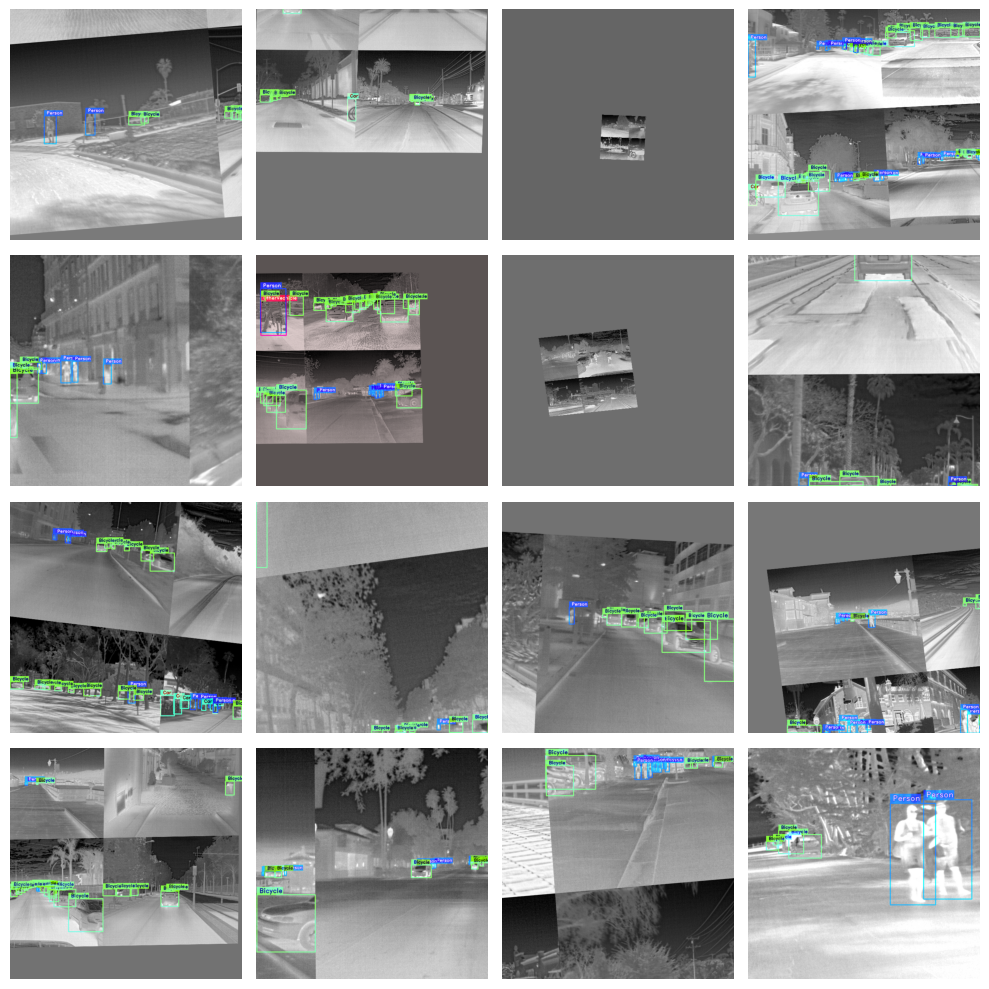

In [24]:
train_data.dataset.plot(plot_transformed_data=True)

In [25]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
}

In [26]:
models_to_train = [
    'yolo_nas_s',
    'yolo_nas_m',
    'yolo_nas_l'
]
 
CHECKPOINT_DIR = 'checkpoints'
 
for model_to_train in models_to_train:
    trainer = Trainer(
        experiment_name=model_to_train, 
        ckpt_root_dir=CHECKPOINT_DIR
    )
 
    model = models.get(
        model_to_train, 
        num_classes=len(dataset_params['classes']), 
        pretrained_weights="coco"
    )
 
    trainer.train(
        model=model, 
        training_params=train_params, 
        train_loader=train_data, 
        valid_loader=val_data
    )

[2024-02-24 15:22:19] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /home/sjhjrol/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
100%|██████████| 73.1M/73.1M [00:01<00:00, 63.2MB/s]
[2024-02-24 15:22:21] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s
[2024-02-24 15:22:21] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240224_152221_764258`
[2024-02-24 15:22:21] INFO - sg_trainer.py - Checkpoints directory: checkpoints/yolo_nas_s/RUN_20240224_152221_764258
[2024-02-24 15:22:21] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
/home/sjhjrol/anaconda3/envs/flir/lib

The console stream is now moved to checkpoints/yolo_nas_s/RUN_20240224_152221_764258/console_Feb24_15_22_21.txt


[2024-02-24 15:22:24] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            10224      (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         639        (len(train_loader))
    - Gradient updates per epoch:   639        (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_S  (19.02M parameters, 19.02M optimized)
    - Learning Rates and Weight Decays:
      - default: (19.02M parameters). LR: 0.0005 (19.02M parameters) WD: 0.0, (42.14K parameters), WD: 0.0001, (18.98M parameters)

[2024-02-24 15:22:24] INFO - sg_trainer.py - Started training for 5

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.7497
│   ├── Ppyoloeloss/loss_iou = 0.7596
│   ├── Ppyoloeloss/loss_dfl = 0.543
│   └── Ppyoloeloss/loss = 3.0523
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0911
    ├── Ppyoloeloss/loss_iou = 0.6317
    ├── Ppyoloeloss/loss_dfl = 0.4258
    ├── Ppyoloeloss/loss = 2.1486
    ├── Precision@0.50 = 0.0499
    ├── Recall@0.50 = 0.1801
    ├── Map@0.50 = 0.0942
    ├── F1@0.50 = 0.0778
    ├── Best_score_threshold = 0.28
    ├── Precision@0.50:0.95 = 0.0222
    ├── Recall@0.50:0.95 = 0.0801
    ├── Map@0.50:0.95 = 0.041
    └── F1@0.50:0.95 = 0.0347



Validating epoch 1: 100%|██████████| 69/69 [00:24<00:00,  2.80it/s]
[2024-02-24 15:26:22] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240224_152221_764258/ckpt_best.pth
[2024-02-24 15:26:22] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.15189257264137268


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8087
│   │   ├── Epoch N-1      = 1.7497 (↘ -0.9409)
│   │   └── Best until now = 1.7497 (↘ -0.9409)
│   ├── Ppyoloeloss/loss_iou = 0.5475
│   │   ├── Epoch N-1      = 0.7596 (↘ -0.2121)
│   │   └── Best until now = 0.7596 (↘ -0.2121)
│   ├── Ppyoloeloss/loss_dfl = 0.4151
│   │   ├── Epoch N-1      = 0.543  (↘ -0.1278)
│   │   └── Best until now = 0.543  (↘ -0.1278)
│   └── Ppyoloeloss/loss = 1.7714
│       ├── Epoch N-1      = 3.0523 (↘ -1.2809)
│       └── Best until now = 3.0523 (↘ -1.2809)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7277
    │   ├── Epoch N-1      = 1.0911 (↘ -0.3634)
    │   └── Best until now = 1.0911 (↘ -0.3634)
    ├── Ppyoloeloss/loss_iou = 0.5274
    │   ├── Epoch N-1      = 0.6317 (↘ -0.1043)
    │   └── Best until now = 0.6317 (↘ -0.1043)
    ├── Ppyoloeloss/loss_dfl = 0.3917
    │   ├── Epoch N-1      = 0.4258 (↘ -0.0341)
    │   └── Best until now = 0.4258 (↘ -0.0341)
    ├── Ppyoloeloss/lo

Validating epoch 2: 100%|██████████| 69/69 [00:23<00:00,  2.90it/s]
[2024-02-24 15:28:21] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240224_152221_764258/ckpt_best.pth
[2024-02-24 15:28:21] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.1649307757616043


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7735
│   │   ├── Epoch N-1      = 0.8087 (↘ -0.0352)
│   │   └── Best until now = 0.8087 (↘ -0.0352)
│   ├── Ppyoloeloss/loss_iou = 0.534
│   │   ├── Epoch N-1      = 0.5475 (↘ -0.0135)
│   │   └── Best until now = 0.5475 (↘ -0.0135)
│   ├── Ppyoloeloss/loss_dfl = 0.4112
│   │   ├── Epoch N-1      = 0.4151 (↘ -0.0039)
│   │   └── Best until now = 0.4151 (↘ -0.0039)
│   └── Ppyoloeloss/loss = 1.7188
│       ├── Epoch N-1      = 1.7714 (↘ -0.0526)
│       └── Best until now = 1.7714 (↘ -0.0526)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6971
    │   ├── Epoch N-1      = 0.7277 (↘ -0.0306)
    │   └── Best until now = 0.7277 (↘ -0.0306)
    ├── Ppyoloeloss/loss_iou = 0.4804
    │   ├── Epoch N-1      = 0.5274 (↘ -0.047)
    │   └── Best until now = 0.5274 (↘ -0.047)
    ├── Ppyoloeloss/loss_dfl = 0.3755
    │   ├── Epoch N-1      = 0.3917 (↘ -0.0162)
    │   └── Best until now = 0.3917 (↘ -0.0162)
    ├── Ppyoloeloss/loss 

Validating epoch 3: 100%|██████████| 69/69 [00:22<00:00,  3.04it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.773
│   │   ├── Epoch N-1      = 0.7735 (↘ -0.0006)
│   │   └── Best until now = 0.7735 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_iou = 0.5296
│   │   ├── Epoch N-1      = 0.534  (↘ -0.0044)
│   │   └── Best until now = 0.534  (↘ -0.0044)
│   ├── Ppyoloeloss/loss_dfl = 0.4127
│   │   ├── Epoch N-1      = 0.4112 (↗ 0.0014)
│   │   └── Best until now = 0.4112 (↗ 0.0014)
│   └── Ppyoloeloss/loss = 1.7153
│       ├── Epoch N-1      = 1.7188 (↘ -0.0035)
│       └── Best until now = 1.7188 (↘ -0.0035)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7055
    │   ├── Epoch N-1      = 0.6971 (↗ 0.0084)
    │   └── Best until now = 0.6971 (↗ 0.0084)
    ├── Ppyoloeloss/loss_iou = 0.4957
    │   ├── Epoch N-1      = 0.4804 (↗ 0.0152)
    │   └── Best until now = 0.4804 (↗ 0.0152)
    ├── Ppyoloeloss/loss_dfl = 0.3861
    │   ├── Epoch N-1      = 0.3755 (↗ 0.0106)
    │   └── Best until now = 0.3755 (↗ 0.0106)
    ├── Ppyoloeloss/loss = 1.58

Validating epoch 4: 100%|██████████| 69/69 [00:23<00:00,  2.90it/s]
[2024-02-24 15:32:18] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240224_152221_764258/ckpt_best.pth
[2024-02-24 15:32:18] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.17089998722076416


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7556
│   │   ├── Epoch N-1      = 0.773  (↘ -0.0174)
│   │   └── Best until now = 0.773  (↘ -0.0174)
│   ├── Ppyoloeloss/loss_iou = 0.5183
│   │   ├── Epoch N-1      = 0.5296 (↘ -0.0113)
│   │   └── Best until now = 0.5296 (↘ -0.0113)
│   ├── Ppyoloeloss/loss_dfl = 0.4054
│   │   ├── Epoch N-1      = 0.4127 (↘ -0.0072)
│   │   └── Best until now = 0.4112 (↘ -0.0058)
│   └── Ppyoloeloss/loss = 1.6793
│       ├── Epoch N-1      = 1.7153 (↘ -0.036)
│       └── Best until now = 1.7153 (↘ -0.036)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6999
    │   ├── Epoch N-1      = 0.7055 (↘ -0.0056)
    │   └── Best until now = 0.6971 (↗ 0.0028)
    ├── Ppyoloeloss/loss_iou = 0.4777
    │   ├── Epoch N-1      = 0.4957 (↘ -0.018)
    │   └── Best until now = 0.4804 (↘ -0.0027)
    ├── Ppyoloeloss/loss_dfl = 0.3737
    │   ├── Epoch N-1      = 0.3861 (↘ -0.0123)
    │   └── Best until now = 0.3755 (↘ -0.0017)
    ├── Ppyoloeloss/loss =

Validating epoch 5: 100%|██████████| 69/69 [00:24<00:00,  2.85it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.742
│   │   ├── Epoch N-1      = 0.7556 (↘ -0.0135)
│   │   └── Best until now = 0.7556 (↘ -0.0135)
│   ├── Ppyoloeloss/loss_iou = 0.5053
│   │   ├── Epoch N-1      = 0.5183 (↘ -0.013)
│   │   └── Best until now = 0.5183 (↘ -0.013)
│   ├── Ppyoloeloss/loss_dfl = 0.3968
│   │   ├── Epoch N-1      = 0.4054 (↘ -0.0086)
│   │   └── Best until now = 0.4054 (↘ -0.0086)
│   └── Ppyoloeloss/loss = 1.6441
│       ├── Epoch N-1      = 1.6793 (↘ -0.0352)
│       └── Best until now = 1.6793 (↘ -0.0352)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6981
    │   ├── Epoch N-1      = 0.6999 (↘ -0.0018)
    │   └── Best until now = 0.6971 (↗ 0.001)
    ├── Ppyoloeloss/loss_iou = 0.4506
    │   ├── Epoch N-1      = 0.4777 (↘ -0.0271)
    │   └── Best until now = 0.4777 (↘ -0.0271)
    ├── Ppyoloeloss/loss_dfl = 0.3649
    │   ├── Epoch N-1      = 0.3737 (↘ -0.0089)
    │   └── Best until now = 0.3737 (↘ -0.0089)
    ├── Ppyoloeloss/loss = 

Validating epoch 6: 100%|██████████| 69/69 [00:24<00:00,  2.86it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7475
│   │   ├── Epoch N-1      = 0.742  (↗ 0.0054)
│   │   └── Best until now = 0.742  (↗ 0.0054)
│   ├── Ppyoloeloss/loss_iou = 0.5041
│   │   ├── Epoch N-1      = 0.5053 (↘ -0.0012)
│   │   └── Best until now = 0.5053 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.398
│   │   ├── Epoch N-1      = 0.3968 (↗ 0.0012)
│   │   └── Best until now = 0.3968 (↗ 0.0012)
│   └── Ppyoloeloss/loss = 1.6496
│       ├── Epoch N-1      = 1.6441 (↗ 0.0054)
│       └── Best until now = 1.6441 (↗ 0.0054)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7218
    │   ├── Epoch N-1      = 0.6981 (↗ 0.0237)
    │   └── Best until now = 0.6971 (↗ 0.0247)
    ├── Ppyoloeloss/loss_iou = 0.4827
    │   ├── Epoch N-1      = 0.4506 (↗ 0.0322)
    │   └── Best until now = 0.4506 (↗ 0.0322)
    ├── Ppyoloeloss/loss_dfl = 0.3817
    │   ├── Epoch N-1      = 0.3649 (↗ 0.0168)
    │   └── Best until now = 0.3649 (↗ 0.0168)
    ├── Ppyoloeloss/loss = 1.5861
 

Validating epoch 7: 100%|██████████| 69/69 [00:22<00:00,  3.09it/s]
[2024-02-24 15:38:17] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240224_152221_764258/ckpt_best.pth
[2024-02-24 15:38:17] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.17229755222797394


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7411
│   │   ├── Epoch N-1      = 0.7475 (↘ -0.0064)
│   │   └── Best until now = 0.742  (↘ -0.001)
│   ├── Ppyoloeloss/loss_iou = 0.5022
│   │   ├── Epoch N-1      = 0.5041 (↘ -0.002)
│   │   └── Best until now = 0.5041 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.3966
│   │   ├── Epoch N-1      = 0.398  (↘ -0.0013)
│   │   └── Best until now = 0.3968 (↘ -0.0002)
│   └── Ppyoloeloss/loss = 1.6399
│       ├── Epoch N-1      = 1.6496 (↘ -0.0097)
│       └── Best until now = 1.6441 (↘ -0.0042)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6935
    │   ├── Epoch N-1      = 0.7218 (↘ -0.0282)
    │   └── Best until now = 0.6971 (↘ -0.0036)
    ├── Ppyoloeloss/loss_iou = 0.4901
    │   ├── Epoch N-1      = 0.4827 (↗ 0.0074)
    │   └── Best until now = 0.4506 (↗ 0.0396)
    ├── Ppyoloeloss/loss_dfl = 0.376
    │   ├── Epoch N-1      = 0.3817 (↘ -0.0056)
    │   └── Best until now = 0.3649 (↗ 0.0111)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 8: 100%|██████████| 69/69 [00:22<00:00,  3.08it/s]
[2024-02-24 15:40:16] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240224_152221_764258/ckpt_best.pth
[2024-02-24 15:40:16] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.17237608134746552


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7368
│   │   ├── Epoch N-1      = 0.7411 (↘ -0.0042)
│   │   └── Best until now = 0.7411 (↘ -0.0042)
│   ├── Ppyoloeloss/loss_iou = 0.4978
│   │   ├── Epoch N-1      = 0.5022 (↘ -0.0044)
│   │   └── Best until now = 0.5022 (↘ -0.0044)
│   ├── Ppyoloeloss/loss_dfl = 0.3972
│   │   ├── Epoch N-1      = 0.3966 (↗ 0.0006)
│   │   └── Best until now = 0.3966 (↗ 0.0006)
│   └── Ppyoloeloss/loss = 1.6318
│       ├── Epoch N-1      = 1.6399 (↘ -0.0081)
│       └── Best until now = 1.6399 (↘ -0.0081)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6991
    │   ├── Epoch N-1      = 0.6935 (↗ 0.0056)
    │   └── Best until now = 0.6935 (↗ 0.0056)
    ├── Ppyoloeloss/loss_iou = 0.4936
    │   ├── Epoch N-1      = 0.4901 (↗ 0.0034)
    │   └── Best until now = 0.4506 (↗ 0.043)
    ├── Ppyoloeloss/loss_dfl = 0.3792
    │   ├── Epoch N-1      = 0.376  (↗ 0.0031)
    │   └── Best until now = 0.3649 (↗ 0.0143)
    ├── Ppyoloeloss/loss = 1.57

Validating epoch 9: 100%|██████████| 69/69 [00:23<00:00,  2.96it/s]
[2024-02-24 15:42:15] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240224_152221_764258/ckpt_best.pth
[2024-02-24 15:42:15] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.17722253501415253


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7329
│   │   ├── Epoch N-1      = 0.7368 (↘ -0.0039)
│   │   └── Best until now = 0.7368 (↘ -0.0039)
│   ├── Ppyoloeloss/loss_iou = 0.4938
│   │   ├── Epoch N-1      = 0.4978 (↘ -0.004)
│   │   └── Best until now = 0.4978 (↘ -0.004)
│   ├── Ppyoloeloss/loss_dfl = 0.3923
│   │   ├── Epoch N-1      = 0.3972 (↘ -0.005)
│   │   └── Best until now = 0.3966 (↘ -0.0044)
│   └── Ppyoloeloss/loss = 1.6189
│       ├── Epoch N-1      = 1.6318 (↘ -0.0129)
│       └── Best until now = 1.6318 (↘ -0.0129)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6794
    │   ├── Epoch N-1      = 0.6991 (↘ -0.0197)
    │   └── Best until now = 0.6935 (↘ -0.0141)
    ├── Ppyoloeloss/loss_iou = 0.4496
    │   ├── Epoch N-1      = 0.4936 (↘ -0.0439)
    │   └── Best until now = 0.4506 (↘ -0.0009)
    ├── Ppyoloeloss/loss_dfl = 0.3646
    │   ├── Epoch N-1      = 0.3792 (↘ -0.0145)
    │   └── Best until now = 0.3649 (↘ -0.0003)
    ├── Ppyoloeloss/loss 

Validating epoch 10: 100%|██████████| 69/69 [00:22<00:00,  3.02it/s]
[2024-02-24 15:44:14] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240224_152221_764258/ckpt_best.pth
[2024-02-24 15:44:14] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.1785554438829422


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7341
│   │   ├── Epoch N-1      = 0.7329 (↗ 0.0012)
│   │   └── Best until now = 0.7329 (↗ 0.0012)
│   ├── Ppyoloeloss/loss_iou = 0.4926
│   │   ├── Epoch N-1      = 0.4938 (↘ -0.0012)
│   │   └── Best until now = 0.4938 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.3928
│   │   ├── Epoch N-1      = 0.3923 (↗ 0.0005)
│   │   └── Best until now = 0.3923 (↗ 0.0005)
│   └── Ppyoloeloss/loss = 1.6195
│       ├── Epoch N-1      = 1.6189 (↗ 0.0005)
│       └── Best until now = 1.6189 (↗ 0.0005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6837
    │   ├── Epoch N-1      = 0.6794 (↗ 0.0043)
    │   └── Best until now = 0.6794 (↗ 0.0043)
    ├── Ppyoloeloss/loss_iou = 0.4812
    │   ├── Epoch N-1      = 0.4496 (↗ 0.0316)
    │   └── Best until now = 0.4496 (↗ 0.0316)
    ├── Ppyoloeloss/loss_dfl = 0.3751
    │   ├── Epoch N-1      = 0.3646 (↗ 0.0104)
    │   └── Best until now = 0.3646 (↗ 0.0104)
    ├── Ppyoloeloss/loss = 1.54
 

Validating epoch 11: 100%|██████████| 69/69 [00:22<00:00,  3.06it/s]
[2024-02-24 15:46:13] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240224_152221_764258/ckpt_best.pth
[2024-02-24 15:46:13] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.1847621500492096


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7276
│   │   ├── Epoch N-1      = 0.7341 (↘ -0.0065)
│   │   └── Best until now = 0.7329 (↘ -0.0053)
│   ├── Ppyoloeloss/loss_iou = 0.4876
│   │   ├── Epoch N-1      = 0.4926 (↘ -0.005)
│   │   └── Best until now = 0.4926 (↘ -0.005)
│   ├── Ppyoloeloss/loss_dfl = 0.391
│   │   ├── Epoch N-1      = 0.3928 (↘ -0.0018)
│   │   └── Best until now = 0.3923 (↘ -0.0013)
│   └── Ppyoloeloss/loss = 1.6062
│       ├── Epoch N-1      = 1.6195 (↘ -0.0133)
│       └── Best until now = 1.6189 (↘ -0.0127)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6933
    │   ├── Epoch N-1      = 0.6837 (↗ 0.0096)
    │   └── Best until now = 0.6794 (↗ 0.0139)
    ├── Ppyoloeloss/loss_iou = 0.4639
    │   ├── Epoch N-1      = 0.4812 (↘ -0.0172)
    │   └── Best until now = 0.4496 (↗ 0.0143)
    ├── Ppyoloeloss/loss_dfl = 0.3689
    │   ├── Epoch N-1      = 0.3751 (↘ -0.0062)
    │   └── Best until now = 0.3646 (↗ 0.0043)
    ├── Ppyoloeloss/loss = 1

Validating epoch 12: 100%|██████████| 69/69 [00:22<00:00,  3.12it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7219
│   │   ├── Epoch N-1      = 0.7276 (↘ -0.0058)
│   │   └── Best until now = 0.7276 (↘ -0.0058)
│   ├── Ppyoloeloss/loss_iou = 0.4832
│   │   ├── Epoch N-1      = 0.4876 (↘ -0.0044)
│   │   └── Best until now = 0.4876 (↘ -0.0044)
│   ├── Ppyoloeloss/loss_dfl = 0.3887
│   │   ├── Epoch N-1      = 0.391  (↘ -0.0023)
│   │   └── Best until now = 0.391  (↘ -0.0023)
│   └── Ppyoloeloss/loss = 1.5937
│       ├── Epoch N-1      = 1.6062 (↘ -0.0125)
│       └── Best until now = 1.6062 (↘ -0.0125)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7572
    │   ├── Epoch N-1      = 0.6933 (↗ 0.0639)
    │   └── Best until now = 0.6794 (↗ 0.0778)
    ├── Ppyoloeloss/loss_iou = 0.5814
    │   ├── Epoch N-1      = 0.4639 (↗ 0.1174)
    │   └── Best until now = 0.4496 (↗ 0.1317)
    ├── Ppyoloeloss/loss_dfl = 0.429
    │   ├── Epoch N-1      = 0.3689 (↗ 0.0601)
    │   └── Best until now = 0.3646 (↗ 0.0644)
    ├── Ppyoloeloss/loss = 1

Validating epoch 13: 100%|██████████| 69/69 [00:23<00:00,  2.91it/s]
[2024-02-24 15:50:11] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240224_152221_764258/ckpt_best.pth
[2024-02-24 15:50:11] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.18976810574531555


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7214
│   │   ├── Epoch N-1      = 0.7219 (↘ -0.0005)
│   │   └── Best until now = 0.7219 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_iou = 0.4825
│   │   ├── Epoch N-1      = 0.4832 (↘ -0.0006)
│   │   └── Best until now = 0.4832 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.3879
│   │   ├── Epoch N-1      = 0.3887 (↘ -0.0008)
│   │   └── Best until now = 0.3887 (↘ -0.0008)
│   └── Ppyoloeloss/loss = 1.5918
│       ├── Epoch N-1      = 1.5937 (↘ -0.002)
│       └── Best until now = 1.5937 (↘ -0.002)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6638
    │   ├── Epoch N-1      = 0.7572 (↘ -0.0934)
    │   └── Best until now = 0.6794 (↘ -0.0156)
    ├── Ppyoloeloss/loss_iou = 0.4452
    │   ├── Epoch N-1      = 0.5814 (↘ -0.1362)
    │   └── Best until now = 0.4496 (↘ -0.0044)
    ├── Ppyoloeloss/loss_dfl = 0.3623
    │   ├── Epoch N-1      = 0.429  (↘ -0.0667)
    │   └── Best until now = 0.3646 (↘ -0.0024)
    ├── Ppyoloeloss/los

Validating epoch 14: 100%|██████████| 69/69 [00:23<00:00,  2.95it/s]


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7165
│   │   ├── Epoch N-1      = 0.7214 (↘ -0.0048)
│   │   └── Best until now = 0.7214 (↘ -0.0048)
│   ├── Ppyoloeloss/loss_iou = 0.4781
│   │   ├── Epoch N-1      = 0.4825 (↘ -0.0045)
│   │   └── Best until now = 0.4825 (↘ -0.0045)
│   ├── Ppyoloeloss/loss_dfl = 0.3854
│   │   ├── Epoch N-1      = 0.3879 (↘ -0.0025)
│   │   └── Best until now = 0.3879 (↘ -0.0025)
│   └── Ppyoloeloss/loss = 1.58
│       ├── Epoch N-1      = 1.5918 (↘ -0.0118)
│       └── Best until now = 1.5918 (↘ -0.0118)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.708
    │   ├── Epoch N-1      = 0.6638 (↗ 0.0442)
    │   └── Best until now = 0.6638 (↗ 0.0442)
    ├── Ppyoloeloss/loss_iou = 0.4926
    │   ├── Epoch N-1      = 0.4452 (↗ 0.0474)
    │   └── Best until now = 0.4452 (↗ 0.0474)
    ├── Ppyoloeloss/loss_dfl = 0.3844
    │   ├── Epoch N-1      = 0.3623 (↗ 0.0221)
    │   └── Best until now = 0.3623 (↗ 0.0221)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 15: 100%|██████████| 69/69 [00:22<00:00,  3.00it/s]


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7151
│   │   ├── Epoch N-1      = 0.7165 (↘ -0.0014)
│   │   └── Best until now = 0.7165 (↘ -0.0014)
│   ├── Ppyoloeloss/loss_iou = 0.4767
│   │   ├── Epoch N-1      = 0.4781 (↘ -0.0013)
│   │   └── Best until now = 0.4781 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_dfl = 0.3857
│   │   ├── Epoch N-1      = 0.3854 (↗ 0.0004)
│   │   └── Best until now = 0.3854 (↗ 0.0004)
│   └── Ppyoloeloss/loss = 1.5776
│       ├── Epoch N-1      = 1.58   (↘ -0.0024)
│       └── Best until now = 1.58   (↘ -0.0024)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6703
    │   ├── Epoch N-1      = 0.708  (↘ -0.0377)
    │   └── Best until now = 0.6638 (↗ 0.0064)
    ├── Ppyoloeloss/loss_iou = 0.4525
    │   ├── Epoch N-1      = 0.4926 (↘ -0.0401)
    │   └── Best until now = 0.4452 (↗ 0.0073)
    ├── Ppyoloeloss/loss_dfl = 0.3657
    │   ├── Epoch N-1      = 0.3844 (↘ -0.0187)
    │   └── Best until now = 0.3623 (↗ 0.0034)
    ├── Ppyoloeloss/loss =

Validating epoch 16: 100%|██████████| 69/69 [00:23<00:00,  2.99it/s]


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7127
│   │   ├── Epoch N-1      = 0.7151 (↘ -0.0024)
│   │   └── Best until now = 0.7151 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_iou = 0.4748
│   │   ├── Epoch N-1      = 0.4767 (↘ -0.0019)
│   │   └── Best until now = 0.4767 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.386
│   │   ├── Epoch N-1      = 0.3857 (↗ 0.0002)
│   │   └── Best until now = 0.3854 (↗ 0.0006)
│   └── Ppyoloeloss/loss = 1.5735
│       ├── Epoch N-1      = 1.5776 (↘ -0.0041)
│       └── Best until now = 1.5776 (↘ -0.0041)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7225
    │   ├── Epoch N-1      = 0.6703 (↗ 0.0523)
    │   └── Best until now = 0.6638 (↗ 0.0587)
    ├── Ppyoloeloss/loss_iou = 0.5472
    │   ├── Epoch N-1      = 0.4525 (↗ 0.0947)
    │   └── Best until now = 0.4452 (↗ 0.102)
    ├── Ppyoloeloss/loss_dfl = 0.4038
    │   ├── Epoch N-1      = 0.3657 (↗ 0.0381)
    │   └── Best until now = 0.3623 (↗ 0.0416)
    ├── Ppyoloeloss/loss = 1.67

Validating epoch 17: 100%|██████████| 69/69 [00:23<00:00,  2.88it/s]


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7095
│   │   ├── Epoch N-1      = 0.7127 (↘ -0.0031)
│   │   └── Best until now = 0.7127 (↘ -0.0031)
│   ├── Ppyoloeloss/loss_iou = 0.4719
│   │   ├── Epoch N-1      = 0.4748 (↘ -0.003)
│   │   └── Best until now = 0.4748 (↘ -0.003)
│   ├── Ppyoloeloss/loss_dfl = 0.3839
│   │   ├── Epoch N-1      = 0.386  (↘ -0.002)
│   │   └── Best until now = 0.3854 (↘ -0.0014)
│   └── Ppyoloeloss/loss = 1.5653
│       ├── Epoch N-1      = 1.5735 (↘ -0.0082)
│       └── Best until now = 1.5735 (↘ -0.0082)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6899
    │   ├── Epoch N-1      = 0.7225 (↘ -0.0326)
    │   └── Best until now = 0.6638 (↗ 0.0261)
    ├── Ppyoloeloss/loss_iou = 0.4476
    │   ├── Epoch N-1      = 0.5472 (↘ -0.0996)
    │   └── Best until now = 0.4452 (↗ 0.0024)
    ├── Ppyoloeloss/loss_dfl = 0.3633
    │   ├── Epoch N-1      = 0.4038 (↘ -0.0405)
    │   └── Best until now = 0.3623 (↗ 0.001)
    ├── Ppyoloeloss/loss = 1

Validating epoch 18: 100%|██████████| 69/69 [00:23<00:00,  2.96it/s]


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7043
│   │   ├── Epoch N-1      = 0.7095 (↘ -0.0052)
│   │   └── Best until now = 0.7095 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_iou = 0.467
│   │   ├── Epoch N-1      = 0.4719 (↘ -0.0048)
│   │   └── Best until now = 0.4719 (↘ -0.0048)
│   ├── Ppyoloeloss/loss_dfl = 0.3805
│   │   ├── Epoch N-1      = 0.3839 (↘ -0.0034)
│   │   └── Best until now = 0.3839 (↘ -0.0034)
│   └── Ppyoloeloss/loss = 1.5519
│       ├── Epoch N-1      = 1.5653 (↘ -0.0135)
│       └── Best until now = 1.5653 (↘ -0.0135)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6604
    │   ├── Epoch N-1      = 0.6899 (↘ -0.0295)
    │   └── Best until now = 0.6638 (↘ -0.0034)
    ├── Ppyoloeloss/loss_iou = 0.4211
    │   ├── Epoch N-1      = 0.4476 (↘ -0.0265)
    │   └── Best until now = 0.4452 (↘ -0.0241)
    ├── Ppyoloeloss/loss_dfl = 0.3564
    │   ├── Epoch N-1      = 0.3633 (↘ -0.0069)
    │   └── Best until now = 0.3623 (↘ -0.0059)
    ├── Ppyoloeloss/lo

Validating epoch 19: 100%|██████████| 69/69 [00:24<00:00,  2.83it/s]
[2024-02-24 16:02:07] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240224_152221_764258/ckpt_best.pth
[2024-02-24 16:02:07] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.19219990074634552


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7013
│   │   ├── Epoch N-1      = 0.7043 (↘ -0.0031)
│   │   └── Best until now = 0.7043 (↘ -0.0031)
│   ├── Ppyoloeloss/loss_iou = 0.4644
│   │   ├── Epoch N-1      = 0.467  (↘ -0.0026)
│   │   └── Best until now = 0.467  (↘ -0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.3793
│   │   ├── Epoch N-1      = 0.3805 (↘ -0.0012)
│   │   └── Best until now = 0.3805 (↘ -0.0012)
│   └── Ppyoloeloss/loss = 1.545
│       ├── Epoch N-1      = 1.5519 (↘ -0.0069)
│       └── Best until now = 1.5519 (↘ -0.0069)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6733
    │   ├── Epoch N-1      = 0.6604 (↗ 0.0129)
    │   └── Best until now = 0.6604 (↗ 0.0129)
    ├── Ppyoloeloss/loss_iou = 0.4394
    │   ├── Epoch N-1      = 0.4211 (↗ 0.0183)
    │   └── Best until now = 0.4211 (↗ 0.0183)
    ├── Ppyoloeloss/loss_dfl = 0.3586
    │   ├── Epoch N-1      = 0.3564 (↗ 0.0023)
    │   └── Best until now = 0.3564 (↗ 0.0023)
    ├── Ppyoloeloss/loss = 1

Validating epoch 20: 100%|██████████| 69/69 [00:22<00:00,  3.06it/s]


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6974
│   │   ├── Epoch N-1      = 0.7013 (↘ -0.0038)
│   │   └── Best until now = 0.7013 (↘ -0.0038)
│   ├── Ppyoloeloss/loss_iou = 0.4607
│   │   ├── Epoch N-1      = 0.4644 (↘ -0.0037)
│   │   └── Best until now = 0.4644 (↘ -0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.3782
│   │   ├── Epoch N-1      = 0.3793 (↘ -0.0011)
│   │   └── Best until now = 0.3793 (↘ -0.0011)
│   └── Ppyoloeloss/loss = 1.5363
│       ├── Epoch N-1      = 1.545  (↘ -0.0087)
│       └── Best until now = 1.545  (↘ -0.0087)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6898
    │   ├── Epoch N-1      = 0.6733 (↗ 0.0165)
    │   └── Best until now = 0.6604 (↗ 0.0294)
    ├── Ppyoloeloss/loss_iou = 0.4418
    │   ├── Epoch N-1      = 0.4394 (↗ 0.0024)
    │   └── Best until now = 0.4211 (↗ 0.0207)
    ├── Ppyoloeloss/loss_dfl = 0.3634
    │   ├── Epoch N-1      = 0.3586 (↗ 0.0048)
    │   └── Best until now = 0.3564 (↗ 0.007)
    ├── Ppyoloeloss/loss = 1

Validating epoch 21: 100%|██████████| 69/69 [00:23<00:00,  2.89it/s]
[2024-02-24 16:06:04] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240224_152221_764258/ckpt_best.pth
[2024-02-24 16:06:04] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.20458979904651642


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6955
│   │   ├── Epoch N-1      = 0.6974 (↘ -0.0019)
│   │   └── Best until now = 0.6974 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_iou = 0.4602
│   │   ├── Epoch N-1      = 0.4607 (↘ -0.0005)
│   │   └── Best until now = 0.4607 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.3779
│   │   ├── Epoch N-1      = 0.3782 (↘ -0.0002)
│   │   └── Best until now = 0.3782 (↘ -0.0002)
│   └── Ppyoloeloss/loss = 1.5337
│       ├── Epoch N-1      = 1.5363 (↘ -0.0026)
│       └── Best until now = 1.5363 (↘ -0.0026)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6573
    │   ├── Epoch N-1      = 0.6898 (↘ -0.0325)
    │   └── Best until now = 0.6604 (↘ -0.0031)
    ├── Ppyoloeloss/loss_iou = 0.4247
    │   ├── Epoch N-1      = 0.4418 (↘ -0.0171)
    │   └── Best until now = 0.4211 (↗ 0.0036)
    ├── Ppyoloeloss/loss_dfl = 0.3542
    │   ├── Epoch N-1      = 0.3634 (↘ -0.0092)
    │   └── Best until now = 0.3564 (↘ -0.0022)
    ├── Ppyoloeloss/lo

Validating epoch 22: 100%|██████████| 69/69 [00:23<00:00,  2.92it/s]
[2024-02-24 16:08:04] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240224_152221_764258/ckpt_best.pth
[2024-02-24 16:08:04] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.20551720261573792


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6914
│   │   ├── Epoch N-1      = 0.6955 (↘ -0.0042)
│   │   └── Best until now = 0.6955 (↘ -0.0042)
│   ├── Ppyoloeloss/loss_iou = 0.457
│   │   ├── Epoch N-1      = 0.4602 (↘ -0.0032)
│   │   └── Best until now = 0.4602 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.3771
│   │   ├── Epoch N-1      = 0.3779 (↘ -0.0008)
│   │   └── Best until now = 0.3779 (↘ -0.0008)
│   └── Ppyoloeloss/loss = 1.5255
│       ├── Epoch N-1      = 1.5337 (↘ -0.0082)
│       └── Best until now = 1.5337 (↘ -0.0082)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6546
    │   ├── Epoch N-1      = 0.6573 (↘ -0.0027)
    │   └── Best until now = 0.6573 (↘ -0.0027)
    ├── Ppyoloeloss/loss_iou = 0.4313
    │   ├── Epoch N-1      = 0.4247 (↗ 0.0066)
    │   └── Best until now = 0.4211 (↗ 0.0102)
    ├── Ppyoloeloss/loss_dfl = 0.3569
    │   ├── Epoch N-1      = 0.3542 (↗ 0.0027)
    │   └── Best until now = 0.3542 (↗ 0.0027)
    ├── Ppyoloeloss/loss =

Validating epoch 23: 100%|██████████| 69/69 [00:23<00:00,  2.90it/s]
[2024-02-24 16:10:04] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240224_152221_764258/ckpt_best.pth
[2024-02-24 16:10:04] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.20840124785900116


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6893
│   │   ├── Epoch N-1      = 0.6914 (↘ -0.002)
│   │   └── Best until now = 0.6914 (↘ -0.002)
│   ├── Ppyoloeloss/loss_iou = 0.4545
│   │   ├── Epoch N-1      = 0.457  (↘ -0.0025)
│   │   └── Best until now = 0.457  (↘ -0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.3734
│   │   ├── Epoch N-1      = 0.3771 (↘ -0.0037)
│   │   └── Best until now = 0.3771 (↘ -0.0037)
│   └── Ppyoloeloss/loss = 1.5172
│       ├── Epoch N-1      = 1.5255 (↘ -0.0082)
│       └── Best until now = 1.5255 (↘ -0.0082)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6493
    │   ├── Epoch N-1      = 0.6546 (↘ -0.0054)
    │   └── Best until now = 0.6546 (↘ -0.0054)
    ├── Ppyoloeloss/loss_iou = 0.4453
    │   ├── Epoch N-1      = 0.4313 (↗ 0.014)
    │   └── Best until now = 0.4211 (↗ 0.0242)
    ├── Ppyoloeloss/loss_dfl = 0.358
    │   ├── Epoch N-1      = 0.3569 (↗ 0.0011)
    │   └── Best until now = 0.3542 (↗ 0.0038)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 24: 100%|██████████| 69/69 [00:24<00:00,  2.87it/s]


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6873
│   │   ├── Epoch N-1      = 0.6893 (↘ -0.002)
│   │   └── Best until now = 0.6893 (↘ -0.002)
│   ├── Ppyoloeloss/loss_iou = 0.4534
│   │   ├── Epoch N-1      = 0.4545 (↘ -0.0011)
│   │   └── Best until now = 0.4545 (↘ -0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.3737
│   │   ├── Epoch N-1      = 0.3734 (↗ 0.0003)
│   │   └── Best until now = 0.3734 (↗ 0.0003)
│   └── Ppyoloeloss/loss = 1.5144
│       ├── Epoch N-1      = 1.5172 (↘ -0.0028)
│       └── Best until now = 1.5172 (↘ -0.0028)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6596
    │   ├── Epoch N-1      = 0.6493 (↗ 0.0104)
    │   └── Best until now = 0.6493 (↗ 0.0104)
    ├── Ppyoloeloss/loss_iou = 0.4577
    │   ├── Epoch N-1      = 0.4453 (↗ 0.0124)
    │   └── Best until now = 0.4211 (↗ 0.0366)
    ├── Ppyoloeloss/loss_dfl = 0.3624
    │   ├── Epoch N-1      = 0.358  (↗ 0.0044)
    │   └── Best until now = 0.3542 (↗ 0.0082)
    ├── Ppyoloeloss/loss = 1.47

Validating epoch 25: 100%|██████████| 69/69 [00:24<00:00,  2.84it/s]


SUMMARY OF EPOCH 25
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6868
│   │   ├── Epoch N-1      = 0.6873 (↘ -0.0005)
│   │   └── Best until now = 0.6873 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_iou = 0.4519
│   │   ├── Epoch N-1      = 0.4534 (↘ -0.0015)
│   │   └── Best until now = 0.4534 (↘ -0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.3735
│   │   ├── Epoch N-1      = 0.3737 (↘ -0.0002)
│   │   └── Best until now = 0.3734 (↗ 0.0)
│   └── Ppyoloeloss/loss = 1.5122
│       ├── Epoch N-1      = 1.5144 (↘ -0.0022)
│       └── Best until now = 1.5144 (↘ -0.0022)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6572
    │   ├── Epoch N-1      = 0.6596 (↘ -0.0024)
    │   └── Best until now = 0.6493 (↗ 0.0079)
    ├── Ppyoloeloss/loss_iou = 0.4314
    │   ├── Epoch N-1      = 0.4577 (↘ -0.0263)
    │   └── Best until now = 0.4211 (↗ 0.0103)
    ├── Ppyoloeloss/loss_dfl = 0.3532
    │   ├── Epoch N-1      = 0.3624 (↘ -0.0092)
    │   └── Best until now = 0.3542 (↘ -0.001)
    ├── Ppyoloeloss/loss = 1

Validating epoch 26: 100%|██████████| 69/69 [00:24<00:00,  2.83it/s]


SUMMARY OF EPOCH 26
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6821
│   │   ├── Epoch N-1      = 0.6868 (↘ -0.0048)
│   │   └── Best until now = 0.6868 (↘ -0.0048)
│   ├── Ppyoloeloss/loss_iou = 0.4518
│   │   ├── Epoch N-1      = 0.4519 (↘ -0.0002)
│   │   └── Best until now = 0.4519 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.37
│   │   ├── Epoch N-1      = 0.3735 (↘ -0.0035)
│   │   └── Best until now = 0.3734 (↘ -0.0034)
│   └── Ppyoloeloss/loss = 1.5038
│       ├── Epoch N-1      = 1.5122 (↘ -0.0084)
│       └── Best until now = 1.5122 (↘ -0.0084)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6597
    │   ├── Epoch N-1      = 0.6572 (↗ 0.0024)
    │   └── Best until now = 0.6493 (↗ 0.0104)
    ├── Ppyoloeloss/loss_iou = 0.4492
    │   ├── Epoch N-1      = 0.4314 (↗ 0.0178)
    │   └── Best until now = 0.4211 (↗ 0.0281)
    ├── Ppyoloeloss/loss_dfl = 0.361
    │   ├── Epoch N-1      = 0.3532 (↗ 0.0078)
    │   └── Best until now = 0.3532 (↗ 0.0078)
    ├── Ppyoloeloss/loss = 1.4

Validating epoch 27: 100%|██████████| 69/69 [00:22<00:00,  3.00it/s]


SUMMARY OF EPOCH 27
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6805
│   │   ├── Epoch N-1      = 0.6821 (↘ -0.0016)
│   │   └── Best until now = 0.6821 (↘ -0.0016)
│   ├── Ppyoloeloss/loss_iou = 0.4479
│   │   ├── Epoch N-1      = 0.4518 (↘ -0.0038)
│   │   └── Best until now = 0.4518 (↘ -0.0038)
│   ├── Ppyoloeloss/loss_dfl = 0.3697
│   │   ├── Epoch N-1      = 0.37   (↘ -0.0003)
│   │   └── Best until now = 0.37   (↘ -0.0003)
│   └── Ppyoloeloss/loss = 1.4981
│       ├── Epoch N-1      = 1.5038 (↘ -0.0057)
│       └── Best until now = 1.5038 (↘ -0.0057)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6538
    │   ├── Epoch N-1      = 0.6597 (↘ -0.0058)
    │   └── Best until now = 0.6493 (↗ 0.0046)
    ├── Ppyoloeloss/loss_iou = 0.4298
    │   ├── Epoch N-1      = 0.4492 (↘ -0.0194)
    │   └── Best until now = 0.4211 (↗ 0.0087)
    ├── Ppyoloeloss/loss_dfl = 0.3542
    │   ├── Epoch N-1      = 0.361  (↘ -0.0068)
    │   └── Best until now = 0.3532 (↗ 0.001)
    ├── Ppyoloeloss/loss 

Validating epoch 28: 100%|██████████| 69/69 [00:22<00:00,  3.01it/s]


SUMMARY OF EPOCH 28
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6768
│   │   ├── Epoch N-1      = 0.6805 (↘ -0.0036)
│   │   └── Best until now = 0.6805 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_iou = 0.4435
│   │   ├── Epoch N-1      = 0.4479 (↘ -0.0044)
│   │   └── Best until now = 0.4479 (↘ -0.0044)
│   ├── Ppyoloeloss/loss_dfl = 0.3697
│   │   ├── Epoch N-1      = 0.3697 (↗ 0.0)
│   │   └── Best until now = 0.3697 (↗ 0.0)
│   └── Ppyoloeloss/loss = 1.4901
│       ├── Epoch N-1      = 1.4981 (↘ -0.008)
│       └── Best until now = 1.4981 (↘ -0.008)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6517
    │   ├── Epoch N-1      = 0.6538 (↘ -0.0022)
    │   └── Best until now = 0.6493 (↗ 0.0024)
    ├── Ppyoloeloss/loss_iou = 0.4142
    │   ├── Epoch N-1      = 0.4298 (↘ -0.0157)
    │   └── Best until now = 0.4211 (↘ -0.0069)
    ├── Ppyoloeloss/loss_dfl = 0.3487
    │   ├── Epoch N-1      = 0.3542 (↘ -0.0055)
    │   └── Best until now = 0.3532 (↘ -0.0045)
    ├── Ppyoloeloss/loss = 1.414

Validating epoch 29: 100%|██████████| 69/69 [00:24<00:00,  2.79it/s]


SUMMARY OF EPOCH 29
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6724
│   │   ├── Epoch N-1      = 0.6768 (↘ -0.0044)
│   │   └── Best until now = 0.6768 (↘ -0.0044)
│   ├── Ppyoloeloss/loss_iou = 0.4431
│   │   ├── Epoch N-1      = 0.4435 (↘ -0.0004)
│   │   └── Best until now = 0.4435 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.3679
│   │   ├── Epoch N-1      = 0.3697 (↘ -0.0017)
│   │   └── Best until now = 0.3697 (↘ -0.0017)
│   └── Ppyoloeloss/loss = 1.4834
│       ├── Epoch N-1      = 1.4901 (↘ -0.0066)
│       └── Best until now = 1.4901 (↘ -0.0066)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6557
    │   ├── Epoch N-1      = 0.6517 (↗ 0.004)
    │   └── Best until now = 0.6493 (↗ 0.0064)
    ├── Ppyoloeloss/loss_iou = 0.4448
    │   ├── Epoch N-1      = 0.4142 (↗ 0.0306)
    │   └── Best until now = 0.4142 (↗ 0.0306)
    ├── Ppyoloeloss/loss_dfl = 0.3592
    │   ├── Epoch N-1      = 0.3487 (↗ 0.0105)
    │   └── Best until now = 0.3487 (↗ 0.0105)
    ├── Ppyoloeloss/loss = 1

Validating epoch 30: 100%|██████████| 69/69 [00:23<00:00,  2.93it/s]
[2024-02-24 16:24:03] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240224_152221_764258/ckpt_best.pth
[2024-02-24 16:24:03] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.21318845450878143


SUMMARY OF EPOCH 30
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6737
│   │   ├── Epoch N-1      = 0.6724 (↗ 0.0013)
│   │   └── Best until now = 0.6724 (↗ 0.0013)
│   ├── Ppyoloeloss/loss_iou = 0.4421
│   │   ├── Epoch N-1      = 0.4431 (↘ -0.001)
│   │   └── Best until now = 0.4431 (↘ -0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.3668
│   │   ├── Epoch N-1      = 0.3679 (↘ -0.0011)
│   │   └── Best until now = 0.3679 (↘ -0.0011)
│   └── Ppyoloeloss/loss = 1.4827
│       ├── Epoch N-1      = 1.4834 (↘ -0.0007)
│       └── Best until now = 1.4834 (↘ -0.0007)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6498
    │   ├── Epoch N-1      = 0.6557 (↘ -0.0058)
    │   └── Best until now = 0.6493 (↗ 0.0006)
    ├── Ppyoloeloss/loss_iou = 0.447
    │   ├── Epoch N-1      = 0.4448 (↗ 0.0022)
    │   └── Best until now = 0.4142 (↗ 0.0328)
    ├── Ppyoloeloss/loss_dfl = 0.3543
    │   ├── Epoch N-1      = 0.3592 (↘ -0.0049)
    │   └── Best until now = 0.3487 (↗ 0.0056)
    ├── Ppyoloeloss/loss = 1.4

Validating epoch 31: 100%|██████████| 69/69 [00:24<00:00,  2.85it/s]
[2024-02-24 16:26:03] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240224_152221_764258/ckpt_best.pth
[2024-02-24 16:26:03] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.215218186378479


SUMMARY OF EPOCH 31
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6664
│   │   ├── Epoch N-1      = 0.6737 (↘ -0.0074)
│   │   └── Best until now = 0.6724 (↘ -0.006)
│   ├── Ppyoloeloss/loss_iou = 0.4366
│   │   ├── Epoch N-1      = 0.4421 (↘ -0.0055)
│   │   └── Best until now = 0.4421 (↘ -0.0055)
│   ├── Ppyoloeloss/loss_dfl = 0.3633
│   │   ├── Epoch N-1      = 0.3668 (↘ -0.0035)
│   │   └── Best until now = 0.3668 (↘ -0.0035)
│   └── Ppyoloeloss/loss = 1.4663
│       ├── Epoch N-1      = 1.4827 (↘ -0.0164)
│       └── Best until now = 1.4827 (↘ -0.0164)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.644
    │   ├── Epoch N-1      = 0.6498 (↘ -0.0059)
    │   └── Best until now = 0.6493 (↘ -0.0053)
    ├── Ppyoloeloss/loss_iou = 0.4266
    │   ├── Epoch N-1      = 0.447  (↘ -0.0204)
    │   └── Best until now = 0.4142 (↗ 0.0124)
    ├── Ppyoloeloss/loss_dfl = 0.3513
    │   ├── Epoch N-1      = 0.3543 (↘ -0.003)
    │   └── Best until now = 0.3487 (↗ 0.0026)
    ├── Ppyoloeloss/loss =

Validating epoch 32: 100%|██████████| 69/69 [00:23<00:00,  2.97it/s]
[2024-02-24 16:28:02] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240224_152221_764258/ckpt_best.pth
[2024-02-24 16:28:02] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.22967851161956787


SUMMARY OF EPOCH 32
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6654
│   │   ├── Epoch N-1      = 0.6664 (↘ -0.001)
│   │   └── Best until now = 0.6664 (↘ -0.001)
│   ├── Ppyoloeloss/loss_iou = 0.4362
│   │   ├── Epoch N-1      = 0.4366 (↘ -0.0004)
│   │   └── Best until now = 0.4366 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.3629
│   │   ├── Epoch N-1      = 0.3633 (↘ -0.0004)
│   │   └── Best until now = 0.3633 (↘ -0.0004)
│   └── Ppyoloeloss/loss = 1.4645
│       ├── Epoch N-1      = 1.4663 (↘ -0.0018)
│       └── Best until now = 1.4663 (↘ -0.0018)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6285
    │   ├── Epoch N-1      = 0.644  (↘ -0.0155)
    │   └── Best until now = 0.644  (↘ -0.0155)
    ├── Ppyoloeloss/loss_iou = 0.4158
    │   ├── Epoch N-1      = 0.4266 (↘ -0.0108)
    │   └── Best until now = 0.4142 (↗ 0.0016)
    ├── Ppyoloeloss/loss_dfl = 0.3475
    │   ├── Epoch N-1      = 0.3513 (↘ -0.0038)
    │   └── Best until now = 0.3487 (↘ -0.0013)
    ├── Ppyoloeloss/loss

Validating epoch 33: 100%|██████████| 69/69 [00:23<00:00,  2.88it/s]


SUMMARY OF EPOCH 33
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6648
│   │   ├── Epoch N-1      = 0.6654 (↘ -0.0006)
│   │   └── Best until now = 0.6654 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_iou = 0.4349
│   │   ├── Epoch N-1      = 0.4362 (↘ -0.0013)
│   │   └── Best until now = 0.4362 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_dfl = 0.3614
│   │   ├── Epoch N-1      = 0.3629 (↘ -0.0015)
│   │   └── Best until now = 0.3629 (↘ -0.0015)
│   └── Ppyoloeloss/loss = 1.4611
│       ├── Epoch N-1      = 1.4645 (↘ -0.0034)
│       └── Best until now = 1.4645 (↘ -0.0034)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6581
    │   ├── Epoch N-1      = 0.6285 (↗ 0.0296)
    │   └── Best until now = 0.6285 (↗ 0.0296)
    ├── Ppyoloeloss/loss_iou = 0.4467
    │   ├── Epoch N-1      = 0.4158 (↗ 0.0309)
    │   └── Best until now = 0.4142 (↗ 0.0325)
    ├── Ppyoloeloss/loss_dfl = 0.3596
    │   ├── Epoch N-1      = 0.3475 (↗ 0.0121)
    │   └── Best until now = 0.3475 (↗ 0.0121)
    ├── Ppyoloeloss/loss = 

Validating epoch 34: 100%|██████████| 69/69 [00:23<00:00,  2.95it/s]


SUMMARY OF EPOCH 34
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6595
│   │   ├── Epoch N-1      = 0.6648 (↘ -0.0053)
│   │   └── Best until now = 0.6648 (↘ -0.0053)
│   ├── Ppyoloeloss/loss_iou = 0.4311
│   │   ├── Epoch N-1      = 0.4349 (↘ -0.0038)
│   │   └── Best until now = 0.4349 (↘ -0.0038)
│   ├── Ppyoloeloss/loss_dfl = 0.3592
│   │   ├── Epoch N-1      = 0.3614 (↘ -0.0021)
│   │   └── Best until now = 0.3614 (↘ -0.0021)
│   └── Ppyoloeloss/loss = 1.4499
│       ├── Epoch N-1      = 1.4611 (↘ -0.0112)
│       └── Best until now = 1.4611 (↘ -0.0112)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6299
    │   ├── Epoch N-1      = 0.6581 (↘ -0.0283)
    │   └── Best until now = 0.6285 (↗ 0.0013)
    ├── Ppyoloeloss/loss_iou = 0.4035
    │   ├── Epoch N-1      = 0.4467 (↘ -0.0432)
    │   └── Best until now = 0.4142 (↘ -0.0107)
    ├── Ppyoloeloss/loss_dfl = 0.3427
    │   ├── Epoch N-1      = 0.3596 (↘ -0.0169)
    │   └── Best until now = 0.3475 (↘ -0.0048)
    ├── Ppyoloeloss/lo

Validating epoch 35: 100%|██████████| 69/69 [00:23<00:00,  2.94it/s]


SUMMARY OF EPOCH 35
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6568
│   │   ├── Epoch N-1      = 0.6595 (↘ -0.0027)
│   │   └── Best until now = 0.6595 (↘ -0.0027)
│   ├── Ppyoloeloss/loss_iou = 0.4284
│   │   ├── Epoch N-1      = 0.4311 (↘ -0.0026)
│   │   └── Best until now = 0.4311 (↘ -0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.3589
│   │   ├── Epoch N-1      = 0.3592 (↘ -0.0003)
│   │   └── Best until now = 0.3592 (↘ -0.0003)
│   └── Ppyoloeloss/loss = 1.4442
│       ├── Epoch N-1      = 1.4499 (↘ -0.0057)
│       └── Best until now = 1.4499 (↘ -0.0057)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6325
    │   ├── Epoch N-1      = 0.6299 (↗ 0.0026)
    │   └── Best until now = 0.6285 (↗ 0.004)
    ├── Ppyoloeloss/loss_iou = 0.4283
    │   ├── Epoch N-1      = 0.4035 (↗ 0.0248)
    │   └── Best until now = 0.4035 (↗ 0.0248)
    ├── Ppyoloeloss/loss_dfl = 0.3499
    │   ├── Epoch N-1      = 0.3427 (↗ 0.0072)
    │   └── Best until now = 0.3427 (↗ 0.0072)
    ├── Ppyoloeloss/loss = 1

Validating epoch 36: 100%|██████████| 69/69 [00:24<00:00,  2.80it/s]


SUMMARY OF EPOCH 36
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6585
│   │   ├── Epoch N-1      = 0.6568 (↗ 0.0017)
│   │   └── Best until now = 0.6568 (↗ 0.0017)
│   ├── Ppyoloeloss/loss_iou = 0.4276
│   │   ├── Epoch N-1      = 0.4284 (↘ -0.0008)
│   │   └── Best until now = 0.4284 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.3585
│   │   ├── Epoch N-1      = 0.3589 (↘ -0.0004)
│   │   └── Best until now = 0.3589 (↘ -0.0004)
│   └── Ppyoloeloss/loss = 1.4447
│       ├── Epoch N-1      = 1.4442 (↗ 0.0005)
│       └── Best until now = 1.4442 (↗ 0.0005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6342
    │   ├── Epoch N-1      = 0.6325 (↗ 0.0017)
    │   └── Best until now = 0.6285 (↗ 0.0057)
    ├── Ppyoloeloss/loss_iou = 0.4088
    │   ├── Epoch N-1      = 0.4283 (↘ -0.0195)
    │   └── Best until now = 0.4035 (↗ 0.0053)
    ├── Ppyoloeloss/loss_dfl = 0.3444
    │   ├── Epoch N-1      = 0.3499 (↘ -0.0056)
    │   └── Best until now = 0.3427 (↗ 0.0017)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 37: 100%|██████████| 69/69 [00:23<00:00,  2.92it/s]


SUMMARY OF EPOCH 37
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6529
│   │   ├── Epoch N-1      = 0.6585 (↘ -0.0056)
│   │   └── Best until now = 0.6568 (↘ -0.0039)
│   ├── Ppyoloeloss/loss_iou = 0.424
│   │   ├── Epoch N-1      = 0.4276 (↘ -0.0036)
│   │   └── Best until now = 0.4276 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_dfl = 0.3574
│   │   ├── Epoch N-1      = 0.3585 (↘ -0.0011)
│   │   └── Best until now = 0.3585 (↘ -0.0011)
│   └── Ppyoloeloss/loss = 1.4343
│       ├── Epoch N-1      = 1.4447 (↘ -0.0104)
│       └── Best until now = 1.4442 (↘ -0.0099)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6338
    │   ├── Epoch N-1      = 0.6342 (↘ -0.0005)
    │   └── Best until now = 0.6285 (↗ 0.0052)
    ├── Ppyoloeloss/loss_iou = 0.4207
    │   ├── Epoch N-1      = 0.4088 (↗ 0.0119)
    │   └── Best until now = 0.4035 (↗ 0.0172)
    ├── Ppyoloeloss/loss_dfl = 0.3476
    │   ├── Epoch N-1      = 0.3444 (↗ 0.0033)
    │   └── Best until now = 0.3427 (↗ 0.0049)
    ├── Ppyoloeloss/loss = 

Validating epoch 38: 100%|██████████| 69/69 [00:23<00:00,  2.94it/s]


SUMMARY OF EPOCH 38
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6506
│   │   ├── Epoch N-1      = 0.6529 (↘ -0.0023)
│   │   └── Best until now = 0.6529 (↘ -0.0023)
│   ├── Ppyoloeloss/loss_iou = 0.4269
│   │   ├── Epoch N-1      = 0.424  (↗ 0.0029)
│   │   └── Best until now = 0.424  (↗ 0.0029)
│   ├── Ppyoloeloss/loss_dfl = 0.3569
│   │   ├── Epoch N-1      = 0.3574 (↘ -0.0006)
│   │   └── Best until now = 0.3574 (↘ -0.0006)
│   └── Ppyoloeloss/loss = 1.4343
│       ├── Epoch N-1      = 1.4343 (↗ 1e-04)
│       └── Best until now = 1.4343 (↗ 1e-04)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6324
    │   ├── Epoch N-1      = 0.6338 (↘ -0.0014)
    │   └── Best until now = 0.6285 (↗ 0.0039)
    ├── Ppyoloeloss/loss_iou = 0.4235
    │   ├── Epoch N-1      = 0.4207 (↗ 0.0028)
    │   └── Best until now = 0.4035 (↗ 0.02)
    ├── Ppyoloeloss/loss_dfl = 0.346
    │   ├── Epoch N-1      = 0.3476 (↘ -0.0017)
    │   └── Best until now = 0.3427 (↗ 0.0033)
    ├── Ppyoloeloss/loss = 1.4019


Validating epoch 39: 100%|██████████| 69/69 [00:23<00:00,  2.94it/s]
[2024-02-24 16:41:59] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240224_152221_764258/ckpt_best.pth
[2024-02-24 16:41:59] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2316100299358368


SUMMARY OF EPOCH 39
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6491
│   │   ├── Epoch N-1      = 0.6506 (↘ -0.0015)
│   │   └── Best until now = 0.6506 (↘ -0.0015)
│   ├── Ppyoloeloss/loss_iou = 0.422
│   │   ├── Epoch N-1      = 0.4269 (↘ -0.0048)
│   │   └── Best until now = 0.424  (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.3548
│   │   ├── Epoch N-1      = 0.3569 (↘ -0.0021)
│   │   └── Best until now = 0.3569 (↘ -0.0021)
│   └── Ppyoloeloss/loss = 1.4259
│       ├── Epoch N-1      = 1.4343 (↘ -0.0084)
│       └── Best until now = 1.4343 (↘ -0.0083)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6244
    │   ├── Epoch N-1      = 0.6324 (↘ -0.008)
    │   └── Best until now = 0.6285 (↘ -0.0041)
    ├── Ppyoloeloss/loss_iou = 0.407
    │   ├── Epoch N-1      = 0.4235 (↘ -0.0165)
    │   └── Best until now = 0.4035 (↗ 0.0035)
    ├── Ppyoloeloss/loss_dfl = 0.3431
    │   ├── Epoch N-1      = 0.346  (↘ -0.0028)
    │   └── Best until now = 0.3427 (↗ 0.0004)
    ├── Ppyoloeloss/loss = 

Validating epoch 40: 100%|██████████| 69/69 [00:23<00:00,  2.92it/s]


SUMMARY OF EPOCH 40
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6461
│   │   ├── Epoch N-1      = 0.6491 (↘ -0.003)
│   │   └── Best until now = 0.6491 (↘ -0.003)
│   ├── Ppyoloeloss/loss_iou = 0.4221
│   │   ├── Epoch N-1      = 0.422  (↗ 1e-04)
│   │   └── Best until now = 0.422  (↗ 1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.3537
│   │   ├── Epoch N-1      = 0.3548 (↘ -0.0011)
│   │   └── Best until now = 0.3548 (↘ -0.0011)
│   └── Ppyoloeloss/loss = 1.4219
│       ├── Epoch N-1      = 1.4259 (↘ -0.004)
│       └── Best until now = 1.4259 (↘ -0.004)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6197
    │   ├── Epoch N-1      = 0.6244 (↘ -0.0047)
    │   └── Best until now = 0.6244 (↘ -0.0047)
    ├── Ppyoloeloss/loss_iou = 0.4173
    │   ├── Epoch N-1      = 0.407  (↗ 0.0102)
    │   └── Best until now = 0.4035 (↗ 0.0138)
    ├── Ppyoloeloss/loss_dfl = 0.3452
    │   ├── Epoch N-1      = 0.3431 (↗ 0.0021)
    │   └── Best until now = 0.3427 (↗ 0.0025)
    ├── Ppyoloeloss/loss = 1.3822

Validating epoch 41: 100%|██████████| 69/69 [00:24<00:00,  2.83it/s]


SUMMARY OF EPOCH 41
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6441
│   │   ├── Epoch N-1      = 0.6461 (↘ -0.0021)
│   │   └── Best until now = 0.6461 (↘ -0.0021)
│   ├── Ppyoloeloss/loss_iou = 0.4206
│   │   ├── Epoch N-1      = 0.4221 (↘ -0.0015)
│   │   └── Best until now = 0.422  (↘ -0.0014)
│   ├── Ppyoloeloss/loss_dfl = 0.3523
│   │   ├── Epoch N-1      = 0.3537 (↘ -0.0014)
│   │   └── Best until now = 0.3537 (↘ -0.0014)
│   └── Ppyoloeloss/loss = 1.417
│       ├── Epoch N-1      = 1.4219 (↘ -0.005)
│       └── Best until now = 1.4219 (↘ -0.005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6217
    │   ├── Epoch N-1      = 0.6197 (↗ 0.002)
    │   └── Best until now = 0.6197 (↗ 0.002)
    ├── Ppyoloeloss/loss_iou = 0.4046
    │   ├── Epoch N-1      = 0.4173 (↘ -0.0127)
    │   └── Best until now = 0.4035 (↗ 0.0011)
    ├── Ppyoloeloss/loss_dfl = 0.3403
    │   ├── Epoch N-1      = 0.3452 (↘ -0.0049)
    │   └── Best until now = 0.3427 (↘ -0.0024)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 42: 100%|██████████| 69/69 [00:23<00:00,  2.96it/s]


SUMMARY OF EPOCH 42
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6442
│   │   ├── Epoch N-1      = 0.6441 (↗ 1e-04)
│   │   └── Best until now = 0.6441 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_iou = 0.4223
│   │   ├── Epoch N-1      = 0.4206 (↗ 0.0017)
│   │   └── Best until now = 0.4206 (↗ 0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.3522
│   │   ├── Epoch N-1      = 0.3523 (↘ -0.0)
│   │   └── Best until now = 0.3523 (↘ -0.0)
│   └── Ppyoloeloss/loss = 1.4187
│       ├── Epoch N-1      = 1.417  (↗ 0.0017)
│       └── Best until now = 1.417  (↗ 0.0017)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6272
    │   ├── Epoch N-1      = 0.6217 (↗ 0.0055)
    │   └── Best until now = 0.6197 (↗ 0.0075)
    ├── Ppyoloeloss/loss_iou = 0.4255
    │   ├── Epoch N-1      = 0.4046 (↗ 0.0209)
    │   └── Best until now = 0.4035 (↗ 0.022)
    ├── Ppyoloeloss/loss_dfl = 0.3447
    │   ├── Epoch N-1      = 0.3403 (↗ 0.0044)
    │   └── Best until now = 0.3403 (↗ 0.0044)
    ├── Ppyoloeloss/loss = 1.3974
    │   

Validating epoch 43: 100%|██████████| 69/69 [00:23<00:00,  2.89it/s]


SUMMARY OF EPOCH 43
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6424
│   │   ├── Epoch N-1      = 0.6442 (↘ -0.0018)
│   │   └── Best until now = 0.6441 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_iou = 0.4186
│   │   ├── Epoch N-1      = 0.4223 (↘ -0.0037)
│   │   └── Best until now = 0.4206 (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.3524
│   │   ├── Epoch N-1      = 0.3522 (↗ 1e-04)
│   │   └── Best until now = 0.3522 (↗ 1e-04)
│   └── Ppyoloeloss/loss = 1.4133
│       ├── Epoch N-1      = 1.4187 (↘ -0.0054)
│       └── Best until now = 1.417  (↘ -0.0037)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6226
    │   ├── Epoch N-1      = 0.6272 (↘ -0.0045)
    │   └── Best until now = 0.6197 (↗ 0.0029)
    ├── Ppyoloeloss/loss_iou = 0.423
    │   ├── Epoch N-1      = 0.4255 (↘ -0.0025)
    │   └── Best until now = 0.4035 (↗ 0.0195)
    ├── Ppyoloeloss/loss_dfl = 0.3461
    │   ├── Epoch N-1      = 0.3447 (↗ 0.0014)
    │   └── Best until now = 0.3403 (↗ 0.0057)
    ├── Ppyoloeloss/loss = 1.3

Validating epoch 44: 100%|██████████| 69/69 [00:23<00:00,  2.88it/s]
[2024-02-24 16:52:02] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240224_152221_764258/ckpt_best.pth
[2024-02-24 16:52:02] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.23616018891334534


SUMMARY OF EPOCH 44
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6415
│   │   ├── Epoch N-1      = 0.6424 (↘ -0.0009)
│   │   └── Best until now = 0.6424 (↘ -0.0009)
│   ├── Ppyoloeloss/loss_iou = 0.4176
│   │   ├── Epoch N-1      = 0.4186 (↘ -0.001)
│   │   └── Best until now = 0.4186 (↘ -0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.3521
│   │   ├── Epoch N-1      = 0.3524 (↘ -0.0003)
│   │   └── Best until now = 0.3522 (↘ -0.0002)
│   └── Ppyoloeloss/loss = 1.4112
│       ├── Epoch N-1      = 1.4133 (↘ -0.0021)
│       └── Best until now = 1.4133 (↘ -0.0021)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6146
    │   ├── Epoch N-1      = 0.6226 (↘ -0.008)
    │   └── Best until now = 0.6197 (↘ -0.0051)
    ├── Ppyoloeloss/loss_iou = 0.4014
    │   ├── Epoch N-1      = 0.423  (↘ -0.0216)
    │   └── Best until now = 0.4035 (↘ -0.0021)
    ├── Ppyoloeloss/loss_dfl = 0.3394
    │   ├── Epoch N-1      = 0.3461 (↘ -0.0067)
    │   └── Best until now = 0.3403 (↘ -0.001)
    ├── Ppyoloeloss/loss 

Validating epoch 45: 100%|██████████| 69/69 [00:24<00:00,  2.81it/s]


SUMMARY OF EPOCH 45
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6397
│   │   ├── Epoch N-1      = 0.6415 (↘ -0.0018)
│   │   └── Best until now = 0.6415 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_iou = 0.4162
│   │   ├── Epoch N-1      = 0.4176 (↘ -0.0013)
│   │   └── Best until now = 0.4176 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_dfl = 0.3505
│   │   ├── Epoch N-1      = 0.3521 (↘ -0.0016)
│   │   └── Best until now = 0.3521 (↘ -0.0016)
│   └── Ppyoloeloss/loss = 1.4065
│       ├── Epoch N-1      = 1.4112 (↘ -0.0047)
│       └── Best until now = 1.4112 (↘ -0.0047)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6224
    │   ├── Epoch N-1      = 0.6146 (↗ 0.0078)
    │   └── Best until now = 0.6146 (↗ 0.0078)
    ├── Ppyoloeloss/loss_iou = 0.4156
    │   ├── Epoch N-1      = 0.4014 (↗ 0.0142)
    │   └── Best until now = 0.4014 (↗ 0.0142)
    ├── Ppyoloeloss/loss_dfl = 0.342
    │   ├── Epoch N-1      = 0.3394 (↗ 0.0026)
    │   └── Best until now = 0.3394 (↗ 0.0026)
    ├── Ppyoloeloss/loss = 1

Validating epoch 46: 100%|██████████| 69/69 [00:23<00:00,  2.96it/s]


SUMMARY OF EPOCH 46
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6391
│   │   ├── Epoch N-1      = 0.6397 (↘ -0.0007)
│   │   └── Best until now = 0.6397 (↘ -0.0007)
│   ├── Ppyoloeloss/loss_iou = 0.4156
│   │   ├── Epoch N-1      = 0.4162 (↘ -0.0007)
│   │   └── Best until now = 0.4162 (↘ -0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.35
│   │   ├── Epoch N-1      = 0.3505 (↘ -0.0006)
│   │   └── Best until now = 0.3505 (↘ -0.0006)
│   └── Ppyoloeloss/loss = 1.4046
│       ├── Epoch N-1      = 1.4065 (↘ -0.0019)
│       └── Best until now = 1.4065 (↘ -0.0019)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6207
    │   ├── Epoch N-1      = 0.6224 (↘ -0.0016)
    │   └── Best until now = 0.6146 (↗ 0.0061)
    ├── Ppyoloeloss/loss_iou = 0.4086
    │   ├── Epoch N-1      = 0.4156 (↘ -0.007)
    │   └── Best until now = 0.4014 (↗ 0.0072)
    ├── Ppyoloeloss/loss_dfl = 0.3401
    │   ├── Epoch N-1      = 0.342  (↘ -0.0018)
    │   └── Best until now = 0.3394 (↗ 0.0008)
    ├── Ppyoloeloss/loss = 

Validating epoch 47: 100%|██████████| 69/69 [00:23<00:00,  2.94it/s]


SUMMARY OF EPOCH 47
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6371
│   │   ├── Epoch N-1      = 0.6391 (↘ -0.0019)
│   │   └── Best until now = 0.6391 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_iou = 0.4112
│   │   ├── Epoch N-1      = 0.4156 (↘ -0.0043)
│   │   └── Best until now = 0.4156 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_dfl = 0.348
│   │   ├── Epoch N-1      = 0.35   (↘ -0.002)
│   │   └── Best until now = 0.35   (↘ -0.002)
│   └── Ppyoloeloss/loss = 1.3964
│       ├── Epoch N-1      = 1.4046 (↘ -0.0083)
│       └── Best until now = 1.4046 (↘ -0.0083)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6222
    │   ├── Epoch N-1      = 0.6207 (↗ 0.0014)
    │   └── Best until now = 0.6146 (↗ 0.0076)
    ├── Ppyoloeloss/loss_iou = 0.4179
    │   ├── Epoch N-1      = 0.4086 (↗ 0.0093)
    │   └── Best until now = 0.4014 (↗ 0.0165)
    ├── Ppyoloeloss/loss_dfl = 0.3434
    │   ├── Epoch N-1      = 0.3401 (↗ 0.0032)
    │   └── Best until now = 0.3394 (↗ 0.004)
    ├── Ppyoloeloss/loss = 1.38

Validating epoch 48: 100%|██████████| 69/69 [00:22<00:00,  3.05it/s]


SUMMARY OF EPOCH 48
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6353
│   │   ├── Epoch N-1      = 0.6371 (↘ -0.0019)
│   │   └── Best until now = 0.6371 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_iou = 0.4132
│   │   ├── Epoch N-1      = 0.4112 (↗ 0.002)
│   │   └── Best until now = 0.4112 (↗ 0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.3474
│   │   ├── Epoch N-1      = 0.348  (↘ -0.0006)
│   │   └── Best until now = 0.348  (↘ -0.0006)
│   └── Ppyoloeloss/loss = 1.3959
│       ├── Epoch N-1      = 1.3964 (↘ -0.0005)
│       └── Best until now = 1.3964 (↘ -0.0005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6176
    │   ├── Epoch N-1      = 0.6222 (↘ -0.0045)
    │   └── Best until now = 0.6146 (↗ 0.003)
    ├── Ppyoloeloss/loss_iou = 0.4027
    │   ├── Epoch N-1      = 0.4179 (↘ -0.0152)
    │   └── Best until now = 0.4014 (↗ 0.0013)
    ├── Ppyoloeloss/loss_dfl = 0.3404
    │   ├── Epoch N-1      = 0.3434 (↘ -0.0029)
    │   └── Best until now = 0.3394 (↗ 0.0011)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 49: 100%|██████████| 69/69 [00:23<00:00,  2.92it/s]


SUMMARY OF EPOCH 49
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6348
│   │   ├── Epoch N-1      = 0.6353 (↘ -0.0005)
│   │   └── Best until now = 0.6353 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_iou = 0.4119
│   │   ├── Epoch N-1      = 0.4132 (↘ -0.0013)
│   │   └── Best until now = 0.4112 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.3477
│   │   ├── Epoch N-1      = 0.3474 (↗ 0.0004)
│   │   └── Best until now = 0.3474 (↗ 0.0004)
│   └── Ppyoloeloss/loss = 1.3945
│       ├── Epoch N-1      = 1.3959 (↘ -0.0014)
│       └── Best until now = 1.3959 (↘ -0.0014)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6171
    │   ├── Epoch N-1      = 0.6176 (↘ -0.0006)
    │   └── Best until now = 0.6146 (↗ 0.0025)
    ├── Ppyoloeloss/loss_iou = 0.4027
    │   ├── Epoch N-1      = 0.4027 (↘ -0.0)
    │   └── Best until now = 0.4014 (↗ 0.0013)
    ├── Ppyoloeloss/loss_dfl = 0.3378
    │   ├── Epoch N-1      = 0.3404 (↘ -0.0026)
    │   └── Best until now = 0.3394 (↘ -0.0015)
    ├── Ppyoloeloss/loss = 1.

[2024-02-24 17:02:05] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 50: 100%|██████████| 69/69 [00:23<00:00,  2.90it/s]
[2024-02-24 17:02:29] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
[2024-02-24 17:02:29] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_m_coco.pth" to /home/sjhjrol/.cache/torch/hub/checkpoints/yolo_nas_m_coco.pth
100%|██████████| 196M/196M [00:06<00:00, 33.4MB/s] 
[2024-02-24 17:02:36] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_m
[2024-02-24 17:02:36] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240224_170236_59

The console stream is now moved to checkpoints/yolo_nas_m/RUN_20240224_170236_592674/console_Feb24_17_02_36.txt


[2024-02-24 17:02:36] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
/home/sjhjrol/anaconda3/envs/flir/lib/python3.9/site-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/home/sjhjrol/anaconda3/envs/flir/lib/python3.9/site-packages/super_gradients/training/utils/optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
[2024-02-24 17:02:39] INFO - sg_trainer_utils.py - TRAINING PARAME

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.6574
│   ├── Ppyoloeloss/loss_iou = 0.7228
│   ├── Ppyoloeloss/loss_dfl = 0.4712
│   └── Ppyoloeloss/loss = 2.8514
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9618
    ├── Ppyoloeloss/loss_iou = 0.6061
    ├── Ppyoloeloss/loss_dfl = 0.3724
    ├── Ppyoloeloss/loss = 1.9403
    ├── Precision@0.50 = 0.2531
    ├── Recall@0.50 = 0.2169
    ├── Map@0.50 = 0.154
    ├── F1@0.50 = 0.1343
    ├── Best_score_threshold = 0.34
    ├── Precision@0.50:0.95 = 0.1237
    ├── Recall@0.50:0.95 = 0.0977
    ├── Map@0.50:0.95 = 0.0647
    └── F1@0.50:0.95 = 0.0613



Validating epoch 1: 100%|██████████| 69/69 [00:25<00:00,  2.73it/s]
[2024-02-24 17:07:59] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/RUN_20240224_170236_592674/ckpt_best.pth
[2024-02-24 17:07:59] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.1813899725675583


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7795
│   │   ├── Epoch N-1      = 1.6574 (↘ -0.8779)
│   │   └── Best until now = 1.6574 (↘ -0.8779)
│   ├── Ppyoloeloss/loss_iou = 0.5206
│   │   ├── Epoch N-1      = 0.7228 (↘ -0.2022)
│   │   └── Best until now = 0.7228 (↘ -0.2022)
│   ├── Ppyoloeloss/loss_dfl = 0.402
│   │   ├── Epoch N-1      = 0.4712 (↘ -0.0692)
│   │   └── Best until now = 0.4712 (↘ -0.0692)
│   └── Ppyoloeloss/loss = 1.7021
│       ├── Epoch N-1      = 2.8514 (↘ -1.1493)
│       └── Best until now = 2.8514 (↘ -1.1493)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7047
    │   ├── Epoch N-1      = 0.9618 (↘ -0.2571)
    │   └── Best until now = 0.9618 (↘ -0.2571)
    ├── Ppyoloeloss/loss_iou = 0.4971
    │   ├── Epoch N-1      = 0.6061 (↘ -0.109)
    │   └── Best until now = 0.6061 (↘ -0.109)
    ├── Ppyoloeloss/loss_dfl = 0.3783
    │   ├── Epoch N-1      = 0.3724 (↗ 0.006)
    │   └── Best until now = 0.3724 (↗ 0.006)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 2: 100%|██████████| 69/69 [00:25<00:00,  2.75it/s]
[2024-02-24 17:10:42] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/RUN_20240224_170236_592674/ckpt_best.pth
[2024-02-24 17:10:42] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.18593692779541016


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7536
│   │   ├── Epoch N-1      = 0.7795 (↘ -0.0259)
│   │   └── Best until now = 0.7795 (↘ -0.0259)
│   ├── Ppyoloeloss/loss_iou = 0.5099
│   │   ├── Epoch N-1      = 0.5206 (↘ -0.0107)
│   │   └── Best until now = 0.5206 (↘ -0.0107)
│   ├── Ppyoloeloss/loss_dfl = 0.403
│   │   ├── Epoch N-1      = 0.402  (↗ 0.001)
│   │   └── Best until now = 0.402  (↗ 0.001)
│   └── Ppyoloeloss/loss = 1.6665
│       ├── Epoch N-1      = 1.7021 (↘ -0.0356)
│       └── Best until now = 1.7021 (↘ -0.0356)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6695
    │   ├── Epoch N-1      = 0.7047 (↘ -0.0352)
    │   └── Best until now = 0.7047 (↘ -0.0352)
    ├── Ppyoloeloss/loss_iou = 0.4375
    │   ├── Epoch N-1      = 0.4971 (↘ -0.0596)
    │   └── Best until now = 0.4971 (↘ -0.0596)
    ├── Ppyoloeloss/loss_dfl = 0.3614
    │   ├── Epoch N-1      = 0.3783 (↘ -0.017)
    │   └── Best until now = 0.3724 (↘ -0.011)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 3: 100%|██████████| 69/69 [00:25<00:00,  2.74it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7592
│   │   ├── Epoch N-1      = 0.7536 (↗ 0.0055)
│   │   └── Best until now = 0.7536 (↗ 0.0055)
│   ├── Ppyoloeloss/loss_iou = 0.5109
│   │   ├── Epoch N-1      = 0.5099 (↗ 0.0011)
│   │   └── Best until now = 0.5099 (↗ 0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.4076
│   │   ├── Epoch N-1      = 0.403  (↗ 0.0046)
│   │   └── Best until now = 0.402  (↗ 0.0056)
│   └── Ppyoloeloss/loss = 1.6777
│       ├── Epoch N-1      = 1.6665 (↗ 0.0112)
│       └── Best until now = 1.6665 (↗ 0.0112)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6931
    │   ├── Epoch N-1      = 0.6695 (↗ 0.0236)
    │   └── Best until now = 0.6695 (↗ 0.0236)
    ├── Ppyoloeloss/loss_iou = 0.4762
    │   ├── Epoch N-1      = 0.4375 (↗ 0.0387)
    │   └── Best until now = 0.4375 (↗ 0.0387)
    ├── Ppyoloeloss/loss_dfl = 0.3815
    │   ├── Epoch N-1      = 0.3614 (↗ 0.0201)
    │   └── Best until now = 0.3614 (↗ 0.0201)
    ├── Ppyoloeloss/loss = 1.5508
  

Validating epoch 4: 100%|██████████| 69/69 [00:25<00:00,  2.75it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7374
│   │   ├── Epoch N-1      = 0.7592 (↘ -0.0218)
│   │   └── Best until now = 0.7536 (↘ -0.0163)
│   ├── Ppyoloeloss/loss_iou = 0.4962
│   │   ├── Epoch N-1      = 0.5109 (↘ -0.0148)
│   │   └── Best until now = 0.5099 (↘ -0.0137)
│   ├── Ppyoloeloss/loss_dfl = 0.4009
│   │   ├── Epoch N-1      = 0.4076 (↘ -0.0067)
│   │   └── Best until now = 0.402  (↘ -0.0011)
│   └── Ppyoloeloss/loss = 1.6344
│       ├── Epoch N-1      = 1.6777 (↘ -0.0433)
│       └── Best until now = 1.6665 (↘ -0.0321)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6746
    │   ├── Epoch N-1      = 0.6931 (↘ -0.0185)
    │   └── Best until now = 0.6695 (↗ 0.0051)
    ├── Ppyoloeloss/loss_iou = 0.4489
    │   ├── Epoch N-1      = 0.4762 (↘ -0.0273)
    │   └── Best until now = 0.4375 (↗ 0.0114)
    ├── Ppyoloeloss/loss_dfl = 0.3662
    │   ├── Epoch N-1      = 0.3815 (↘ -0.0153)
    │   └── Best until now = 0.3614 (↗ 0.0048)
    ├── Ppyoloeloss/loss 

Validating epoch 5: 100%|██████████| 69/69 [00:24<00:00,  2.77it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7273
│   │   ├── Epoch N-1      = 0.7374 (↘ -0.0101)
│   │   └── Best until now = 0.7374 (↘ -0.0101)
│   ├── Ppyoloeloss/loss_iou = 0.4878
│   │   ├── Epoch N-1      = 0.4962 (↘ -0.0083)
│   │   └── Best until now = 0.4962 (↘ -0.0083)
│   ├── Ppyoloeloss/loss_dfl = 0.3948
│   │   ├── Epoch N-1      = 0.4009 (↘ -0.0061)
│   │   └── Best until now = 0.4009 (↘ -0.0061)
│   └── Ppyoloeloss/loss = 1.6099
│       ├── Epoch N-1      = 1.6344 (↘ -0.0245)
│       └── Best until now = 1.6344 (↘ -0.0245)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6663
    │   ├── Epoch N-1      = 0.6746 (↘ -0.0083)
    │   └── Best until now = 0.6695 (↘ -0.0032)
    ├── Ppyoloeloss/loss_iou = 0.4444
    │   ├── Epoch N-1      = 0.4489 (↘ -0.0045)
    │   └── Best until now = 0.4375 (↗ 0.0069)
    ├── Ppyoloeloss/loss_dfl = 0.3673
    │   ├── Epoch N-1      = 0.3662 (↗ 0.0011)
    │   └── Best until now = 0.3614 (↗ 0.0059)
    ├── Ppyoloeloss/loss 

Validating epoch 6: 100%|██████████| 69/69 [00:24<00:00,  2.76it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.729
│   │   ├── Epoch N-1      = 0.7273 (↗ 0.0017)
│   │   └── Best until now = 0.7273 (↗ 0.0017)
│   ├── Ppyoloeloss/loss_iou = 0.4834
│   │   ├── Epoch N-1      = 0.4878 (↘ -0.0045)
│   │   └── Best until now = 0.4878 (↘ -0.0045)
│   ├── Ppyoloeloss/loss_dfl = 0.3954
│   │   ├── Epoch N-1      = 0.3948 (↗ 0.0006)
│   │   └── Best until now = 0.3948 (↗ 0.0006)
│   └── Ppyoloeloss/loss = 1.6078
│       ├── Epoch N-1      = 1.6099 (↘ -0.0021)
│       └── Best until now = 1.6099 (↘ -0.0021)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6796
    │   ├── Epoch N-1      = 0.6663 (↗ 0.0133)
    │   └── Best until now = 0.6663 (↗ 0.0133)
    ├── Ppyoloeloss/loss_iou = 0.4708
    │   ├── Epoch N-1      = 0.4444 (↗ 0.0264)
    │   └── Best until now = 0.4375 (↗ 0.0333)
    ├── Ppyoloeloss/loss_dfl = 0.3773
    │   ├── Epoch N-1      = 0.3673 (↗ 0.0099)
    │   └── Best until now = 0.3614 (↗ 0.0159)
    ├── Ppyoloeloss/loss = 1.5277

Validating epoch 7: 100%|██████████| 69/69 [00:24<00:00,  2.81it/s]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7223
│   │   ├── Epoch N-1      = 0.729  (↘ -0.0067)
│   │   └── Best until now = 0.7273 (↘ -0.005)
│   ├── Ppyoloeloss/loss_iou = 0.4804
│   │   ├── Epoch N-1      = 0.4834 (↘ -0.003)
│   │   └── Best until now = 0.4834 (↘ -0.003)
│   ├── Ppyoloeloss/loss_dfl = 0.3942
│   │   ├── Epoch N-1      = 0.3954 (↘ -0.0013)
│   │   └── Best until now = 0.3948 (↘ -0.0006)
│   └── Ppyoloeloss/loss = 1.5969
│       ├── Epoch N-1      = 1.6078 (↘ -0.0109)
│       └── Best until now = 1.6078 (↘ -0.0109)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6942
    │   ├── Epoch N-1      = 0.6796 (↗ 0.0145)
    │   └── Best until now = 0.6663 (↗ 0.0279)
    ├── Ppyoloeloss/loss_iou = 0.4679
    │   ├── Epoch N-1      = 0.4708 (↘ -0.0029)
    │   └── Best until now = 0.4375 (↗ 0.0305)
    ├── Ppyoloeloss/loss_dfl = 0.3791
    │   ├── Epoch N-1      = 0.3773 (↗ 0.0019)
    │   └── Best until now = 0.3614 (↗ 0.0178)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 8: 100%|██████████| 69/69 [00:24<00:00,  2.78it/s]
[2024-02-24 17:26:54] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/RUN_20240224_170236_592674/ckpt_best.pth
[2024-02-24 17:26:54] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.18731911480426788


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7225
│   │   ├── Epoch N-1      = 0.7223 (↗ 0.0002)
│   │   └── Best until now = 0.7223 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_iou = 0.4778
│   │   ├── Epoch N-1      = 0.4804 (↘ -0.0026)
│   │   └── Best until now = 0.4804 (↘ -0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.396
│   │   ├── Epoch N-1      = 0.3942 (↗ 0.0018)
│   │   └── Best until now = 0.3942 (↗ 0.0018)
│   └── Ppyoloeloss/loss = 1.5963
│       ├── Epoch N-1      = 1.5969 (↘ -0.0006)
│       └── Best until now = 1.5969 (↘ -0.0006)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6639
    │   ├── Epoch N-1      = 0.6942 (↘ -0.0302)
    │   └── Best until now = 0.6663 (↘ -0.0024)
    ├── Ppyoloeloss/loss_iou = 0.4427
    │   ├── Epoch N-1      = 0.4679 (↘ -0.0252)
    │   └── Best until now = 0.4375 (↗ 0.0053)
    ├── Ppyoloeloss/loss_dfl = 0.3669
    │   ├── Epoch N-1      = 0.3791 (↘ -0.0123)
    │   └── Best until now = 0.3614 (↗ 0.0055)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 9: 100%|██████████| 69/69 [00:26<00:00,  2.58it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7151
│   │   ├── Epoch N-1      = 0.7225 (↘ -0.0074)
│   │   └── Best until now = 0.7223 (↘ -0.0072)
│   ├── Ppyoloeloss/loss_iou = 0.4734
│   │   ├── Epoch N-1      = 0.4778 (↘ -0.0043)
│   │   └── Best until now = 0.4778 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_dfl = 0.391
│   │   ├── Epoch N-1      = 0.396  (↘ -0.005)
│   │   └── Best until now = 0.3942 (↘ -0.0031)
│   └── Ppyoloeloss/loss = 1.5796
│       ├── Epoch N-1      = 1.5963 (↘ -0.0167)
│       └── Best until now = 1.5963 (↘ -0.0167)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6713
    │   ├── Epoch N-1      = 0.6639 (↗ 0.0074)
    │   └── Best until now = 0.6639 (↗ 0.0074)
    ├── Ppyoloeloss/loss_iou = 0.4573
    │   ├── Epoch N-1      = 0.4427 (↗ 0.0145)
    │   └── Best until now = 0.4375 (↗ 0.0198)
    ├── Ppyoloeloss/loss_dfl = 0.3745
    │   ├── Epoch N-1      = 0.3669 (↗ 0.0076)
    │   └── Best until now = 0.3614 (↗ 0.0131)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 10: 100%|██████████| 69/69 [00:26<00:00,  2.57it/s]


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7201
│   │   ├── Epoch N-1      = 0.7151 (↗ 0.0051)
│   │   └── Best until now = 0.7151 (↗ 0.0051)
│   ├── Ppyoloeloss/loss_iou = 0.473
│   │   ├── Epoch N-1      = 0.4734 (↘ -0.0004)
│   │   └── Best until now = 0.4734 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.3923
│   │   ├── Epoch N-1      = 0.391  (↗ 0.0013)
│   │   └── Best until now = 0.391  (↗ 0.0013)
│   └── Ppyoloeloss/loss = 1.5855
│       ├── Epoch N-1      = 1.5796 (↗ 0.0059)
│       └── Best until now = 1.5796 (↗ 0.0059)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6798
    │   ├── Epoch N-1      = 0.6713 (↗ 0.0084)
    │   └── Best until now = 0.6639 (↗ 0.0158)
    ├── Ppyoloeloss/loss_iou = 0.4644
    │   ├── Epoch N-1      = 0.4573 (↗ 0.0071)
    │   └── Best until now = 0.4375 (↗ 0.0269)
    ├── Ppyoloeloss/loss_dfl = 0.3778
    │   ├── Epoch N-1      = 0.3745 (↗ 0.0034)
    │   └── Best until now = 0.3614 (↗ 0.0165)
    ├── Ppyoloeloss/loss = 1.522
 

Validating epoch 11: 100%|██████████| 69/69 [00:24<00:00,  2.87it/s]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7126
│   │   ├── Epoch N-1      = 0.7201 (↘ -0.0076)
│   │   └── Best until now = 0.7151 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_iou = 0.4665
│   │   ├── Epoch N-1      = 0.473  (↘ -0.0066)
│   │   └── Best until now = 0.473  (↘ -0.0066)
│   ├── Ppyoloeloss/loss_dfl = 0.3896
│   │   ├── Epoch N-1      = 0.3923 (↘ -0.0027)
│   │   └── Best until now = 0.391  (↘ -0.0014)
│   └── Ppyoloeloss/loss = 1.5687
│       ├── Epoch N-1      = 1.5855 (↘ -0.0168)
│       └── Best until now = 1.5796 (↘ -0.0109)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6767
    │   ├── Epoch N-1      = 0.6798 (↘ -0.0031)
    │   └── Best until now = 0.6639 (↗ 0.0128)
    ├── Ppyoloeloss/loss_iou = 0.4441
    │   ├── Epoch N-1      = 0.4644 (↘ -0.0203)
    │   └── Best until now = 0.4375 (↗ 0.0066)
    ├── Ppyoloeloss/loss_dfl = 0.3688
    │   ├── Epoch N-1      = 0.3778 (↘ -0.009)
    │   └── Best until now = 0.3614 (↗ 0.0075)
    ├── Ppyoloeloss/loss 

Validating epoch 12: 100%|██████████| 69/69 [00:25<00:00,  2.73it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7101
│   │   ├── Epoch N-1      = 0.7126 (↘ -0.0025)
│   │   └── Best until now = 0.7126 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_iou = 0.4661
│   │   ├── Epoch N-1      = 0.4665 (↘ -0.0004)
│   │   └── Best until now = 0.4665 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.3884
│   │   ├── Epoch N-1      = 0.3896 (↘ -0.0012)
│   │   └── Best until now = 0.3896 (↘ -0.0012)
│   └── Ppyoloeloss/loss = 1.5646
│       ├── Epoch N-1      = 1.5687 (↘ -0.0041)
│       └── Best until now = 1.5687 (↘ -0.0041)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.68
    │   ├── Epoch N-1      = 0.6767 (↗ 0.0033)
    │   └── Best until now = 0.6639 (↗ 0.0161)
    ├── Ppyoloeloss/loss_iou = 0.4616
    │   ├── Epoch N-1      = 0.4441 (↗ 0.0175)
    │   └── Best until now = 0.4375 (↗ 0.0241)
    ├── Ppyoloeloss/loss_dfl = 0.3764
    │   ├── Epoch N-1      = 0.3688 (↗ 0.0076)
    │   └── Best until now = 0.3614 (↗ 0.0151)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 13: 100%|██████████| 69/69 [00:24<00:00,  2.83it/s]
[2024-02-24 17:40:36] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/RUN_20240224_170236_592674/ckpt_best.pth
[2024-02-24 17:40:36] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.193740576505661


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7082
│   │   ├── Epoch N-1      = 0.7101 (↘ -0.0019)
│   │   └── Best until now = 0.7101 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_iou = 0.4631
│   │   ├── Epoch N-1      = 0.4661 (↘ -0.0029)
│   │   └── Best until now = 0.4661 (↘ -0.0029)
│   ├── Ppyoloeloss/loss_dfl = 0.3871
│   │   ├── Epoch N-1      = 0.3884 (↘ -0.0013)
│   │   └── Best until now = 0.3884 (↘ -0.0013)
│   └── Ppyoloeloss/loss = 1.5585
│       ├── Epoch N-1      = 1.5646 (↘ -0.0061)
│       └── Best until now = 1.5646 (↘ -0.0061)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6632
    │   ├── Epoch N-1      = 0.68   (↘ -0.0168)
    │   └── Best until now = 0.6639 (↘ -0.0008)
    ├── Ppyoloeloss/loss_iou = 0.434
    │   ├── Epoch N-1      = 0.4616 (↘ -0.0276)
    │   └── Best until now = 0.4375 (↘ -0.0035)
    ├── Ppyoloeloss/loss_dfl = 0.3684
    │   ├── Epoch N-1      = 0.3764 (↘ -0.0081)
    │   └── Best until now = 0.3614 (↗ 0.007)
    ├── Ppyoloeloss/loss

Validating epoch 14: 100%|██████████| 69/69 [00:25<00:00,  2.74it/s]
[2024-02-24 17:43:20] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/RUN_20240224_170236_592674/ckpt_best.pth
[2024-02-24 17:43:20] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.19467094540596008


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7019
│   │   ├── Epoch N-1      = 0.7082 (↘ -0.0063)
│   │   └── Best until now = 0.7082 (↘ -0.0063)
│   ├── Ppyoloeloss/loss_iou = 0.4589
│   │   ├── Epoch N-1      = 0.4631 (↘ -0.0043)
│   │   └── Best until now = 0.4631 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_dfl = 0.3858
│   │   ├── Epoch N-1      = 0.3871 (↘ -0.0014)
│   │   └── Best until now = 0.3871 (↘ -0.0014)
│   └── Ppyoloeloss/loss = 1.5466
│       ├── Epoch N-1      = 1.5585 (↘ -0.0119)
│       └── Best until now = 1.5585 (↘ -0.0119)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6629
    │   ├── Epoch N-1      = 0.6632 (↘ -0.0002)
    │   └── Best until now = 0.6632 (↘ -0.0002)
    ├── Ppyoloeloss/loss_iou = 0.463
    │   ├── Epoch N-1      = 0.434  (↗ 0.0291)
    │   └── Best until now = 0.434  (↗ 0.0291)
    ├── Ppyoloeloss/loss_dfl = 0.3744
    │   ├── Epoch N-1      = 0.3684 (↗ 0.006)
    │   └── Best until now = 0.3614 (↗ 0.013)
    ├── Ppyoloeloss/loss = 1

Validating epoch 15: 100%|██████████| 69/69 [00:24<00:00,  2.77it/s]


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7031
│   │   ├── Epoch N-1      = 0.7019 (↗ 0.0012)
│   │   └── Best until now = 0.7019 (↗ 0.0012)
│   ├── Ppyoloeloss/loss_iou = 0.4581
│   │   ├── Epoch N-1      = 0.4589 (↘ -0.0008)
│   │   └── Best until now = 0.4589 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.386
│   │   ├── Epoch N-1      = 0.3858 (↗ 0.0003)
│   │   └── Best until now = 0.3858 (↗ 0.0003)
│   └── Ppyoloeloss/loss = 1.5473
│       ├── Epoch N-1      = 1.5466 (↗ 0.0007)
│       └── Best until now = 1.5466 (↗ 0.0007)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6693
    │   ├── Epoch N-1      = 0.6629 (↗ 0.0064)
    │   └── Best until now = 0.6629 (↗ 0.0064)
    ├── Ppyoloeloss/loss_iou = 0.4732
    │   ├── Epoch N-1      = 0.463  (↗ 0.0102)
    │   └── Best until now = 0.434  (↗ 0.0393)
    ├── Ppyoloeloss/loss_dfl = 0.3788
    │   ├── Epoch N-1      = 0.3744 (↗ 0.0044)
    │   └── Best until now = 0.3614 (↗ 0.0175)
    ├── Ppyoloeloss/loss = 1.5214


Validating epoch 16: 100%|██████████| 69/69 [00:25<00:00,  2.73it/s]


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7017
│   │   ├── Epoch N-1      = 0.7031 (↘ -0.0015)
│   │   └── Best until now = 0.7019 (↘ -0.0003)
│   ├── Ppyoloeloss/loss_iou = 0.4571
│   │   ├── Epoch N-1      = 0.4581 (↘ -0.0011)
│   │   └── Best until now = 0.4581 (↘ -0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.3852
│   │   ├── Epoch N-1      = 0.386  (↘ -0.0008)
│   │   └── Best until now = 0.3858 (↘ -0.0005)
│   └── Ppyoloeloss/loss = 1.5439
│       ├── Epoch N-1      = 1.5473 (↘ -0.0033)
│       └── Best until now = 1.5466 (↘ -0.0026)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6518
    │   ├── Epoch N-1      = 0.6693 (↘ -0.0175)
    │   └── Best until now = 0.6629 (↘ -0.0111)
    ├── Ppyoloeloss/loss_iou = 0.4245
    │   ├── Epoch N-1      = 0.4732 (↘ -0.0487)
    │   └── Best until now = 0.434  (↘ -0.0094)
    ├── Ppyoloeloss/loss_dfl = 0.3593
    │   ├── Epoch N-1      = 0.3788 (↘ -0.0195)
    │   └── Best until now = 0.3614 (↘ -0.0021)
    ├── Ppyoloeloss/l

Validating epoch 17: 100%|██████████| 69/69 [00:25<00:00,  2.68it/s]
[2024-02-24 17:51:31] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/RUN_20240224_170236_592674/ckpt_best.pth
[2024-02-24 17:51:31] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.19733887910842896


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6966
│   │   ├── Epoch N-1      = 0.7017 (↘ -0.0051)
│   │   └── Best until now = 0.7017 (↘ -0.0051)
│   ├── Ppyoloeloss/loss_iou = 0.4528
│   │   ├── Epoch N-1      = 0.4571 (↘ -0.0043)
│   │   └── Best until now = 0.4571 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_dfl = 0.3833
│   │   ├── Epoch N-1      = 0.3852 (↘ -0.002)
│   │   └── Best until now = 0.3852 (↘ -0.002)
│   └── Ppyoloeloss/loss = 1.5326
│       ├── Epoch N-1      = 1.5439 (↘ -0.0113)
│       └── Best until now = 1.5439 (↘ -0.0113)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6556
    │   ├── Epoch N-1      = 0.6518 (↗ 0.0037)
    │   └── Best until now = 0.6518 (↗ 0.0037)
    ├── Ppyoloeloss/loss_iou = 0.4238
    │   ├── Epoch N-1      = 0.4245 (↘ -0.0007)
    │   └── Best until now = 0.4245 (↘ -0.0007)
    ├── Ppyoloeloss/loss_dfl = 0.3607
    │   ├── Epoch N-1      = 0.3593 (↗ 0.0014)
    │   └── Best until now = 0.3593 (↗ 0.0014)
    ├── Ppyoloeloss/loss = 

Validating epoch 18: 100%|██████████| 69/69 [00:25<00:00,  2.70it/s]
[2024-02-24 17:54:17] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/RUN_20240224_170236_592674/ckpt_best.pth
[2024-02-24 17:54:17] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.20290517807006836


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6905
│   │   ├── Epoch N-1      = 0.6966 (↘ -0.0061)
│   │   └── Best until now = 0.6966 (↘ -0.0061)
│   ├── Ppyoloeloss/loss_iou = 0.4486
│   │   ├── Epoch N-1      = 0.4528 (↘ -0.0041)
│   │   └── Best until now = 0.4528 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_dfl = 0.3793
│   │   ├── Epoch N-1      = 0.3833 (↘ -0.004)
│   │   └── Best until now = 0.3833 (↘ -0.004)
│   └── Ppyoloeloss/loss = 1.5184
│       ├── Epoch N-1      = 1.5326 (↘ -0.0142)
│       └── Best until now = 1.5326 (↘ -0.0142)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6533
    │   ├── Epoch N-1      = 0.6556 (↘ -0.0023)
    │   └── Best until now = 0.6518 (↗ 0.0015)
    ├── Ppyoloeloss/loss_iou = 0.4342
    │   ├── Epoch N-1      = 0.4238 (↗ 0.0104)
    │   └── Best until now = 0.4238 (↗ 0.0104)
    ├── Ppyoloeloss/loss_dfl = 0.3624
    │   ├── Epoch N-1      = 0.3607 (↗ 0.0018)
    │   └── Best until now = 0.3593 (↗ 0.0031)
    ├── Ppyoloeloss/loss = 1

Validating epoch 19: 100%|██████████| 69/69 [00:25<00:00,  2.74it/s]


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6912
│   │   ├── Epoch N-1      = 0.6905 (↗ 0.0007)
│   │   └── Best until now = 0.6905 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_iou = 0.4466
│   │   ├── Epoch N-1      = 0.4486 (↘ -0.0021)
│   │   └── Best until now = 0.4486 (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.3792
│   │   ├── Epoch N-1      = 0.3793 (↘ -1e-04)
│   │   └── Best until now = 0.3793 (↘ -1e-04)
│   └── Ppyoloeloss/loss = 1.517
│       ├── Epoch N-1      = 1.5184 (↘ -0.0014)
│       └── Best until now = 1.5184 (↘ -0.0014)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6603
    │   ├── Epoch N-1      = 0.6533 (↗ 0.007)
    │   └── Best until now = 0.6518 (↗ 0.0085)
    ├── Ppyoloeloss/loss_iou = 0.4538
    │   ├── Epoch N-1      = 0.4342 (↗ 0.0196)
    │   └── Best until now = 0.4238 (↗ 0.03)
    ├── Ppyoloeloss/loss_dfl = 0.3704
    │   ├── Epoch N-1      = 0.3624 (↗ 0.0079)
    │   └── Best until now = 0.3593 (↗ 0.0111)
    ├── Ppyoloeloss/loss = 1.4844
 

Validating epoch 20: 100%|██████████| 69/69 [00:25<00:00,  2.73it/s]


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.686
│   │   ├── Epoch N-1      = 0.6912 (↘ -0.0052)
│   │   └── Best until now = 0.6905 (↘ -0.0045)
│   ├── Ppyoloeloss/loss_iou = 0.4433
│   │   ├── Epoch N-1      = 0.4466 (↘ -0.0033)
│   │   └── Best until now = 0.4466 (↘ -0.0033)
│   ├── Ppyoloeloss/loss_dfl = 0.3775
│   │   ├── Epoch N-1      = 0.3792 (↘ -0.0016)
│   │   └── Best until now = 0.3792 (↘ -0.0016)
│   └── Ppyoloeloss/loss = 1.5068
│       ├── Epoch N-1      = 1.517  (↘ -0.0101)
│       └── Best until now = 1.517  (↘ -0.0101)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.649
    │   ├── Epoch N-1      = 0.6603 (↘ -0.0113)
    │   └── Best until now = 0.6518 (↘ -0.0028)
    ├── Ppyoloeloss/loss_iou = 0.4331
    │   ├── Epoch N-1      = 0.4538 (↘ -0.0206)
    │   └── Best until now = 0.4238 (↗ 0.0094)
    ├── Ppyoloeloss/loss_dfl = 0.3665
    │   ├── Epoch N-1      = 0.3704 (↘ -0.0039)
    │   └── Best until now = 0.3593 (↗ 0.0072)
    ├── Ppyoloeloss/loss 

Validating epoch 21: 100%|██████████| 69/69 [00:26<00:00,  2.64it/s]
[2024-02-24 18:02:29] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/RUN_20240224_170236_592674/ckpt_best.pth
[2024-02-24 18:02:29] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.20307114720344543


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6829
│   │   ├── Epoch N-1      = 0.686  (↘ -0.003)
│   │   └── Best until now = 0.686  (↘ -0.003)
│   ├── Ppyoloeloss/loss_iou = 0.4418
│   │   ├── Epoch N-1      = 0.4433 (↘ -0.0015)
│   │   └── Best until now = 0.4433 (↘ -0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.3771
│   │   ├── Epoch N-1      = 0.3775 (↘ -0.0005)
│   │   └── Best until now = 0.3775 (↘ -0.0005)
│   └── Ppyoloeloss/loss = 1.5018
│       ├── Epoch N-1      = 1.5068 (↘ -0.005)
│       └── Best until now = 1.5068 (↘ -0.005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6508
    │   ├── Epoch N-1      = 0.649  (↗ 0.0018)
    │   └── Best until now = 0.649  (↗ 0.0018)
    ├── Ppyoloeloss/loss_iou = 0.4407
    │   ├── Epoch N-1      = 0.4331 (↗ 0.0076)
    │   └── Best until now = 0.4238 (↗ 0.017)
    ├── Ppyoloeloss/loss_dfl = 0.3669
    │   ├── Epoch N-1      = 0.3665 (↗ 0.0004)
    │   └── Best until now = 0.3593 (↗ 0.0076)
    ├── Ppyoloeloss/loss = 1.458

Validating epoch 22: 100%|██████████| 69/69 [00:24<00:00,  2.76it/s]


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6802
│   │   ├── Epoch N-1      = 0.6829 (↘ -0.0028)
│   │   └── Best until now = 0.6829 (↘ -0.0028)
│   ├── Ppyoloeloss/loss_iou = 0.4411
│   │   ├── Epoch N-1      = 0.4418 (↘ -0.0007)
│   │   └── Best until now = 0.4418 (↘ -0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.3764
│   │   ├── Epoch N-1      = 0.3771 (↘ -0.0007)
│   │   └── Best until now = 0.3771 (↘ -0.0007)
│   └── Ppyoloeloss/loss = 1.4977
│       ├── Epoch N-1      = 1.5018 (↘ -0.0041)
│       └── Best until now = 1.5018 (↘ -0.0041)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6623
    │   ├── Epoch N-1      = 0.6508 (↗ 0.0115)
    │   └── Best until now = 0.649  (↗ 0.0133)
    ├── Ppyoloeloss/loss_iou = 0.4416
    │   ├── Epoch N-1      = 0.4407 (↗ 0.0009)
    │   └── Best until now = 0.4238 (↗ 0.0178)
    ├── Ppyoloeloss/loss_dfl = 0.3671
    │   ├── Epoch N-1      = 0.3669 (↗ 0.0002)
    │   └── Best until now = 0.3593 (↗ 0.0078)
    ├── Ppyoloeloss/loss = 

Validating epoch 23: 100%|██████████| 69/69 [00:25<00:00,  2.75it/s]
[2024-02-24 18:07:57] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/RUN_20240224_170236_592674/ckpt_best.pth
[2024-02-24 18:07:57] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2130102664232254


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.676
│   │   ├── Epoch N-1      = 0.6802 (↘ -0.0042)
│   │   └── Best until now = 0.6802 (↘ -0.0042)
│   ├── Ppyoloeloss/loss_iou = 0.436
│   │   ├── Epoch N-1      = 0.4411 (↘ -0.0051)
│   │   └── Best until now = 0.4411 (↘ -0.0051)
│   ├── Ppyoloeloss/loss_dfl = 0.3721
│   │   ├── Epoch N-1      = 0.3764 (↘ -0.0043)
│   │   └── Best until now = 0.3764 (↘ -0.0043)
│   └── Ppyoloeloss/loss = 1.4841
│       ├── Epoch N-1      = 1.4977 (↘ -0.0136)
│       └── Best until now = 1.4977 (↘ -0.0136)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6467
    │   ├── Epoch N-1      = 0.6623 (↘ -0.0156)
    │   └── Best until now = 0.649  (↘ -0.0023)
    ├── Ppyoloeloss/loss_iou = 0.4359
    │   ├── Epoch N-1      = 0.4416 (↘ -0.0057)
    │   └── Best until now = 0.4238 (↗ 0.0121)
    ├── Ppyoloeloss/loss_dfl = 0.3608
    │   ├── Epoch N-1      = 0.3671 (↘ -0.0063)
    │   └── Best until now = 0.3593 (↗ 0.0015)
    ├── Ppyoloeloss/loss 

Validating epoch 24: 100%|██████████| 69/69 [00:24<00:00,  2.77it/s]


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6754
│   │   ├── Epoch N-1      = 0.676  (↘ -0.0006)
│   │   └── Best until now = 0.676  (↘ -0.0006)
│   ├── Ppyoloeloss/loss_iou = 0.4345
│   │   ├── Epoch N-1      = 0.436  (↘ -0.0015)
│   │   └── Best until now = 0.436  (↘ -0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.3724
│   │   ├── Epoch N-1      = 0.3721 (↗ 0.0003)
│   │   └── Best until now = 0.3721 (↗ 0.0003)
│   └── Ppyoloeloss/loss = 1.4823
│       ├── Epoch N-1      = 1.4841 (↘ -0.0018)
│       └── Best until now = 1.4841 (↘ -0.0018)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6595
    │   ├── Epoch N-1      = 0.6467 (↗ 0.0128)
    │   └── Best until now = 0.6467 (↗ 0.0128)
    ├── Ppyoloeloss/loss_iou = 0.432
    │   ├── Epoch N-1      = 0.4359 (↘ -0.0039)
    │   └── Best until now = 0.4238 (↗ 0.0082)
    ├── Ppyoloeloss/loss_dfl = 0.3627
    │   ├── Epoch N-1      = 0.3608 (↗ 0.0019)
    │   └── Best until now = 0.3593 (↗ 0.0034)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 25: 100%|██████████| 69/69 [00:26<00:00,  2.63it/s]
[2024-02-24 18:13:25] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/RUN_20240224_170236_592674/ckpt_best.pth
[2024-02-24 18:13:25] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2150266170501709


SUMMARY OF EPOCH 25
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6738
│   │   ├── Epoch N-1      = 0.6754 (↘ -0.0016)
│   │   └── Best until now = 0.6754 (↘ -0.0016)
│   ├── Ppyoloeloss/loss_iou = 0.4351
│   │   ├── Epoch N-1      = 0.4345 (↗ 0.0006)
│   │   └── Best until now = 0.4345 (↗ 0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.372
│   │   ├── Epoch N-1      = 0.3724 (↘ -0.0005)
│   │   └── Best until now = 0.3721 (↘ -0.0002)
│   └── Ppyoloeloss/loss = 1.4809
│       ├── Epoch N-1      = 1.4823 (↘ -0.0014)
│       └── Best until now = 1.4823 (↘ -0.0014)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6456
    │   ├── Epoch N-1      = 0.6595 (↘ -0.0139)
    │   └── Best until now = 0.6467 (↘ -0.0011)
    ├── Ppyoloeloss/loss_iou = 0.4286
    │   ├── Epoch N-1      = 0.432  (↘ -0.0034)
    │   └── Best until now = 0.4238 (↗ 0.0048)
    ├── Ppyoloeloss/loss_dfl = 0.3573
    │   ├── Epoch N-1      = 0.3627 (↘ -0.0053)
    │   └── Best until now = 0.3593 (↘ -0.002)
    ├── Ppyoloeloss/loss =

Validating epoch 26: 100%|██████████| 69/69 [00:25<00:00,  2.74it/s]


SUMMARY OF EPOCH 26
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6691
│   │   ├── Epoch N-1      = 0.6738 (↘ -0.0048)
│   │   └── Best until now = 0.6738 (↘ -0.0048)
│   ├── Ppyoloeloss/loss_iou = 0.4302
│   │   ├── Epoch N-1      = 0.4351 (↘ -0.0049)
│   │   └── Best until now = 0.4345 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_dfl = 0.368
│   │   ├── Epoch N-1      = 0.372  (↘ -0.0039)
│   │   └── Best until now = 0.372  (↘ -0.0039)
│   └── Ppyoloeloss/loss = 1.4673
│       ├── Epoch N-1      = 1.4809 (↘ -0.0136)
│       └── Best until now = 1.4809 (↘ -0.0136)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.639
    │   ├── Epoch N-1      = 0.6456 (↘ -0.0065)
    │   └── Best until now = 0.6456 (↘ -0.0065)
    ├── Ppyoloeloss/loss_iou = 0.4009
    │   ├── Epoch N-1      = 0.4286 (↘ -0.0277)
    │   └── Best until now = 0.4238 (↘ -0.0229)
    ├── Ppyoloeloss/loss_dfl = 0.3508
    │   ├── Epoch N-1      = 0.3573 (↘ -0.0066)
    │   └── Best until now = 0.3573 (↘ -0.0066)
    ├── Ppyoloeloss/los

Validating epoch 27: 100%|██████████| 69/69 [00:24<00:00,  2.83it/s]


SUMMARY OF EPOCH 27
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6665
│   │   ├── Epoch N-1      = 0.6691 (↘ -0.0025)
│   │   └── Best until now = 0.6691 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_iou = 0.4281
│   │   ├── Epoch N-1      = 0.4302 (↘ -0.0021)
│   │   └── Best until now = 0.4302 (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.3683
│   │   ├── Epoch N-1      = 0.368  (↗ 0.0002)
│   │   └── Best until now = 0.368  (↗ 0.0002)
│   └── Ppyoloeloss/loss = 1.4629
│       ├── Epoch N-1      = 1.4673 (↘ -0.0044)
│       └── Best until now = 1.4673 (↘ -0.0044)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6478
    │   ├── Epoch N-1      = 0.639  (↗ 0.0087)
    │   └── Best until now = 0.639  (↗ 0.0087)
    ├── Ppyoloeloss/loss_iou = 0.4336
    │   ├── Epoch N-1      = 0.4009 (↗ 0.0327)
    │   └── Best until now = 0.4009 (↗ 0.0327)
    ├── Ppyoloeloss/loss_dfl = 0.3618
    │   ├── Epoch N-1      = 0.3508 (↗ 0.0111)
    │   └── Best until now = 0.3508 (↗ 0.0111)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 28: 100%|██████████| 69/69 [00:24<00:00,  2.78it/s]
[2024-02-24 18:21:36] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/RUN_20240224_170236_592674/ckpt_best.pth
[2024-02-24 18:21:36] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.22070197761058807


SUMMARY OF EPOCH 28
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6646
│   │   ├── Epoch N-1      = 0.6665 (↘ -0.0019)
│   │   └── Best until now = 0.6665 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_iou = 0.4249
│   │   ├── Epoch N-1      = 0.4281 (↘ -0.0032)
│   │   └── Best until now = 0.4281 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.3692
│   │   ├── Epoch N-1      = 0.3683 (↗ 0.0009)
│   │   └── Best until now = 0.368  (↗ 0.0011)
│   └── Ppyoloeloss/loss = 1.4587
│       ├── Epoch N-1      = 1.4629 (↘ -0.0042)
│       └── Best until now = 1.4629 (↘ -0.0042)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6243
    │   ├── Epoch N-1      = 0.6478 (↘ -0.0235)
    │   └── Best until now = 0.639  (↘ -0.0147)
    ├── Ppyoloeloss/loss_iou = 0.4071
    │   ├── Epoch N-1      = 0.4336 (↘ -0.0265)
    │   └── Best until now = 0.4009 (↗ 0.0062)
    ├── Ppyoloeloss/loss_dfl = 0.3508
    │   ├── Epoch N-1      = 0.3618 (↘ -0.0111)
    │   └── Best until now = 0.3508 (↗ 0.0)
    ├── Ppyoloeloss/loss = 1

Validating epoch 29: 100%|██████████| 69/69 [00:25<00:00,  2.71it/s]


SUMMARY OF EPOCH 29
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6597
│   │   ├── Epoch N-1      = 0.6646 (↘ -0.0049)
│   │   └── Best until now = 0.6646 (↘ -0.0049)
│   ├── Ppyoloeloss/loss_iou = 0.4231
│   │   ├── Epoch N-1      = 0.4249 (↘ -0.0018)
│   │   └── Best until now = 0.4249 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.3665
│   │   ├── Epoch N-1      = 0.3692 (↘ -0.0027)
│   │   └── Best until now = 0.368  (↘ -0.0016)
│   └── Ppyoloeloss/loss = 1.4493
│       ├── Epoch N-1      = 1.4587 (↘ -0.0094)
│       └── Best until now = 1.4587 (↘ -0.0094)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6306
    │   ├── Epoch N-1      = 0.6243 (↗ 0.0063)
    │   └── Best until now = 0.6243 (↗ 0.0063)
    ├── Ppyoloeloss/loss_iou = 0.4267
    │   ├── Epoch N-1      = 0.4071 (↗ 0.0196)
    │   └── Best until now = 0.4009 (↗ 0.0258)
    ├── Ppyoloeloss/loss_dfl = 0.3588
    │   ├── Epoch N-1      = 0.3508 (↗ 0.0081)
    │   └── Best until now = 0.3508 (↗ 0.0081)
    ├── Ppyoloeloss/loss = 

Validating epoch 30: 100%|██████████| 69/69 [00:25<00:00,  2.69it/s]


SUMMARY OF EPOCH 30
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6584
│   │   ├── Epoch N-1      = 0.6597 (↘ -0.0014)
│   │   └── Best until now = 0.6597 (↘ -0.0014)
│   ├── Ppyoloeloss/loss_iou = 0.4228
│   │   ├── Epoch N-1      = 0.4231 (↘ -0.0003)
│   │   └── Best until now = 0.4231 (↘ -0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.3653
│   │   ├── Epoch N-1      = 0.3665 (↘ -0.0011)
│   │   └── Best until now = 0.3665 (↘ -0.0011)
│   └── Ppyoloeloss/loss = 1.4465
│       ├── Epoch N-1      = 1.4493 (↘ -0.0028)
│       └── Best until now = 1.4493 (↘ -0.0028)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6415
    │   ├── Epoch N-1      = 0.6306 (↗ 0.011)
    │   └── Best until now = 0.6243 (↗ 0.0172)
    ├── Ppyoloeloss/loss_iou = 0.4223
    │   ├── Epoch N-1      = 0.4267 (↘ -0.0043)
    │   └── Best until now = 0.4009 (↗ 0.0214)
    ├── Ppyoloeloss/loss_dfl = 0.3567
    │   ├── Epoch N-1      = 0.3588 (↘ -0.0022)
    │   └── Best until now = 0.3508 (↗ 0.0059)
    ├── Ppyoloeloss/loss =

Validating epoch 31: 100%|██████████| 69/69 [00:25<00:00,  2.68it/s]
[2024-02-24 18:29:48] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/RUN_20240224_170236_592674/ckpt_best.pth
[2024-02-24 18:29:48] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.22112977504730225


SUMMARY OF EPOCH 31
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6519
│   │   ├── Epoch N-1      = 0.6584 (↘ -0.0064)
│   │   └── Best until now = 0.6584 (↘ -0.0064)
│   ├── Ppyoloeloss/loss_iou = 0.4191
│   │   ├── Epoch N-1      = 0.4228 (↘ -0.0037)
│   │   └── Best until now = 0.4228 (↘ -0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.3622
│   │   ├── Epoch N-1      = 0.3653 (↘ -0.0032)
│   │   └── Best until now = 0.3653 (↘ -0.0032)
│   └── Ppyoloeloss/loss = 1.4332
│       ├── Epoch N-1      = 1.4465 (↘ -0.0133)
│       └── Best until now = 1.4465 (↘ -0.0133)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6306
    │   ├── Epoch N-1      = 0.6415 (↘ -0.0109)
    │   └── Best until now = 0.6243 (↗ 0.0063)
    ├── Ppyoloeloss/loss_iou = 0.4452
    │   ├── Epoch N-1      = 0.4223 (↗ 0.0229)
    │   └── Best until now = 0.4009 (↗ 0.0443)
    ├── Ppyoloeloss/loss_dfl = 0.3607
    │   ├── Epoch N-1      = 0.3567 (↗ 0.004)
    │   └── Best until now = 0.3508 (↗ 0.01)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 32: 100%|██████████| 69/69 [00:25<00:00,  2.75it/s]


SUMMARY OF EPOCH 32
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6531
│   │   ├── Epoch N-1      = 0.6519 (↗ 0.0011)
│   │   └── Best until now = 0.6519 (↗ 0.0011)
│   ├── Ppyoloeloss/loss_iou = 0.4171
│   │   ├── Epoch N-1      = 0.4191 (↘ -0.002)
│   │   └── Best until now = 0.4191 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.3622
│   │   ├── Epoch N-1      = 0.3622 (↗ 0.0)
│   │   └── Best until now = 0.3622 (↗ 0.0)
│   └── Ppyoloeloss/loss = 1.4324
│       ├── Epoch N-1      = 1.4332 (↘ -0.0008)
│       └── Best until now = 1.4332 (↘ -0.0008)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6459
    │   ├── Epoch N-1      = 0.6306 (↗ 0.0153)
    │   └── Best until now = 0.6243 (↗ 0.0216)
    ├── Ppyoloeloss/loss_iou = 0.4565
    │   ├── Epoch N-1      = 0.4452 (↗ 0.0113)
    │   └── Best until now = 0.4009 (↗ 0.0556)
    ├── Ppyoloeloss/loss_dfl = 0.3681
    │   ├── Epoch N-1      = 0.3607 (↗ 0.0074)
    │   └── Best until now = 0.3508 (↗ 0.0174)
    ├── Ppyoloeloss/loss = 1.4705
    │

Validating epoch 33: 100%|██████████| 69/69 [00:25<00:00,  2.75it/s]


SUMMARY OF EPOCH 33
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6473
│   │   ├── Epoch N-1      = 0.6531 (↘ -0.0058)
│   │   └── Best until now = 0.6519 (↘ -0.0047)
│   ├── Ppyoloeloss/loss_iou = 0.4126
│   │   ├── Epoch N-1      = 0.4171 (↘ -0.0045)
│   │   └── Best until now = 0.4171 (↘ -0.0045)
│   ├── Ppyoloeloss/loss_dfl = 0.3594
│   │   ├── Epoch N-1      = 0.3622 (↘ -0.0028)
│   │   └── Best until now = 0.3622 (↘ -0.0027)
│   └── Ppyoloeloss/loss = 1.4194
│       ├── Epoch N-1      = 1.4324 (↘ -0.013)
│       └── Best until now = 1.4324 (↘ -0.013)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6263
    │   ├── Epoch N-1      = 0.6459 (↘ -0.0196)
    │   └── Best until now = 0.6243 (↗ 0.002)
    ├── Ppyoloeloss/loss_iou = 0.4135
    │   ├── Epoch N-1      = 0.4565 (↘ -0.043)
    │   └── Best until now = 0.4009 (↗ 0.0126)
    ├── Ppyoloeloss/loss_dfl = 0.3524
    │   ├── Epoch N-1      = 0.3681 (↘ -0.0157)
    │   └── Best until now = 0.3508 (↗ 0.0017)
    ├── Ppyoloeloss/loss = 1

Validating epoch 34: 100%|██████████| 69/69 [00:25<00:00,  2.74it/s]
[2024-02-24 18:38:02] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/RUN_20240224_170236_592674/ckpt_best.pth
[2024-02-24 18:38:02] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.23073384165763855


SUMMARY OF EPOCH 34
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6438
│   │   ├── Epoch N-1      = 0.6473 (↘ -0.0035)
│   │   └── Best until now = 0.6473 (↘ -0.0035)
│   ├── Ppyoloeloss/loss_iou = 0.4114
│   │   ├── Epoch N-1      = 0.4126 (↘ -0.0013)
│   │   └── Best until now = 0.4126 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_dfl = 0.3582
│   │   ├── Epoch N-1      = 0.3594 (↘ -0.0012)
│   │   └── Best until now = 0.3594 (↘ -0.0012)
│   └── Ppyoloeloss/loss = 1.4134
│       ├── Epoch N-1      = 1.4194 (↘ -0.006)
│       └── Best until now = 1.4194 (↘ -0.006)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6163
    │   ├── Epoch N-1      = 0.6263 (↘ -0.01)
    │   └── Best until now = 0.6243 (↘ -0.008)
    ├── Ppyoloeloss/loss_iou = 0.4029
    │   ├── Epoch N-1      = 0.4135 (↘ -0.0105)
    │   └── Best until now = 0.4009 (↗ 0.002)
    ├── Ppyoloeloss/loss_dfl = 0.3464
    │   ├── Epoch N-1      = 0.3524 (↘ -0.0061)
    │   └── Best until now = 0.3508 (↘ -0.0044)
    ├── Ppyoloeloss/loss = 1

Validating epoch 35: 100%|██████████| 69/69 [00:25<00:00,  2.71it/s]
[2024-02-24 18:40:46] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/RUN_20240224_170236_592674/ckpt_best.pth
[2024-02-24 18:40:46] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.23579879105091095


SUMMARY OF EPOCH 35
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6425
│   │   ├── Epoch N-1      = 0.6438 (↘ -0.0013)
│   │   └── Best until now = 0.6438 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_iou = 0.4108
│   │   ├── Epoch N-1      = 0.4114 (↘ -0.0005)
│   │   └── Best until now = 0.4114 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.3583
│   │   ├── Epoch N-1      = 0.3582 (↗ 1e-04)
│   │   └── Best until now = 0.3582 (↗ 1e-04)
│   └── Ppyoloeloss/loss = 1.4116
│       ├── Epoch N-1      = 1.4134 (↘ -0.0018)
│       └── Best until now = 1.4134 (↘ -0.0018)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6159
    │   ├── Epoch N-1      = 0.6163 (↘ -0.0004)
    │   └── Best until now = 0.6163 (↘ -0.0004)
    ├── Ppyoloeloss/loss_iou = 0.4017
    │   ├── Epoch N-1      = 0.4029 (↘ -0.0013)
    │   └── Best until now = 0.4009 (↗ 0.0007)
    ├── Ppyoloeloss/loss_dfl = 0.3453
    │   ├── Epoch N-1      = 0.3464 (↘ -0.001)
    │   └── Best until now = 0.3464 (↘ -0.001)
    ├── Ppyoloeloss/loss = 1

Validating epoch 36: 100%|██████████| 69/69 [00:25<00:00,  2.71it/s]


SUMMARY OF EPOCH 36
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6418
│   │   ├── Epoch N-1      = 0.6425 (↘ -0.0007)
│   │   └── Best until now = 0.6425 (↘ -0.0007)
│   ├── Ppyoloeloss/loss_iou = 0.4058
│   │   ├── Epoch N-1      = 0.4108 (↘ -0.0051)
│   │   └── Best until now = 0.4108 (↘ -0.0051)
│   ├── Ppyoloeloss/loss_dfl = 0.3576
│   │   ├── Epoch N-1      = 0.3583 (↘ -0.0007)
│   │   └── Best until now = 0.3582 (↘ -0.0007)
│   └── Ppyoloeloss/loss = 1.4051
│       ├── Epoch N-1      = 1.4116 (↘ -0.0065)
│       └── Best until now = 1.4116 (↘ -0.0065)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6219
    │   ├── Epoch N-1      = 0.6159 (↗ 0.0061)
    │   └── Best until now = 0.6159 (↗ 0.0061)
    ├── Ppyoloeloss/loss_iou = 0.4027
    │   ├── Epoch N-1      = 0.4017 (↗ 0.001)
    │   └── Best until now = 0.4009 (↗ 0.0018)
    ├── Ppyoloeloss/loss_dfl = 0.3464
    │   ├── Epoch N-1      = 0.3453 (↗ 0.001)
    │   └── Best until now = 0.3453 (↗ 0.001)
    ├── Ppyoloeloss/loss = 1.3

Validating epoch 37: 100%|██████████| 69/69 [00:25<00:00,  2.73it/s]


SUMMARY OF EPOCH 37
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6379
│   │   ├── Epoch N-1      = 0.6418 (↘ -0.0039)
│   │   └── Best until now = 0.6418 (↘ -0.0039)
│   ├── Ppyoloeloss/loss_iou = 0.4048
│   │   ├── Epoch N-1      = 0.4058 (↘ -0.001)
│   │   └── Best until now = 0.4058 (↘ -0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.3562
│   │   ├── Epoch N-1      = 0.3576 (↘ -0.0013)
│   │   └── Best until now = 0.3576 (↘ -0.0013)
│   └── Ppyoloeloss/loss = 1.3989
│       ├── Epoch N-1      = 1.4051 (↘ -0.0062)
│       └── Best until now = 1.4051 (↘ -0.0062)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6369
    │   ├── Epoch N-1      = 0.6219 (↗ 0.015)
    │   └── Best until now = 0.6159 (↗ 0.0211)
    ├── Ppyoloeloss/loss_iou = 0.4472
    │   ├── Epoch N-1      = 0.4027 (↗ 0.0445)
    │   └── Best until now = 0.4009 (↗ 0.0463)
    ├── Ppyoloeloss/loss_dfl = 0.3613
    │   ├── Epoch N-1      = 0.3464 (↗ 0.0149)
    │   └── Best until now = 0.3453 (↗ 0.016)
    ├── Ppyoloeloss/loss = 1.44

Validating epoch 38: 100%|██████████| 69/69 [00:24<00:00,  2.81it/s]


SUMMARY OF EPOCH 38
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6353
│   │   ├── Epoch N-1      = 0.6379 (↘ -0.0026)
│   │   └── Best until now = 0.6379 (↘ -0.0026)
│   ├── Ppyoloeloss/loss_iou = 0.4056
│   │   ├── Epoch N-1      = 0.4048 (↗ 0.0009)
│   │   └── Best until now = 0.4048 (↗ 0.0009)
│   ├── Ppyoloeloss/loss_dfl = 0.3556
│   │   ├── Epoch N-1      = 0.3562 (↘ -0.0006)
│   │   └── Best until now = 0.3562 (↘ -0.0006)
│   └── Ppyoloeloss/loss = 1.3965
│       ├── Epoch N-1      = 1.3989 (↘ -0.0024)
│       └── Best until now = 1.3989 (↘ -0.0024)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6198
    │   ├── Epoch N-1      = 0.6369 (↘ -0.0172)
    │   └── Best until now = 0.6159 (↗ 0.0039)
    ├── Ppyoloeloss/loss_iou = 0.4179
    │   ├── Epoch N-1      = 0.4472 (↘ -0.0293)
    │   └── Best until now = 0.4009 (↗ 0.017)
    ├── Ppyoloeloss/loss_dfl = 0.3504
    │   ├── Epoch N-1      = 0.3613 (↘ -0.0109)
    │   └── Best until now = 0.3453 (↗ 0.0051)
    ├── Ppyoloeloss/loss = 

Validating epoch 39: 100%|██████████| 69/69 [00:24<00:00,  2.83it/s]


SUMMARY OF EPOCH 39
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6325
│   │   ├── Epoch N-1      = 0.6353 (↘ -0.0027)
│   │   └── Best until now = 0.6353 (↘ -0.0027)
│   ├── Ppyoloeloss/loss_iou = 0.4025
│   │   ├── Epoch N-1      = 0.4056 (↘ -0.0032)
│   │   └── Best until now = 0.4048 (↘ -0.0023)
│   ├── Ppyoloeloss/loss_dfl = 0.3538
│   │   ├── Epoch N-1      = 0.3556 (↘ -0.0018)
│   │   └── Best until now = 0.3556 (↘ -0.0018)
│   └── Ppyoloeloss/loss = 1.3889
│       ├── Epoch N-1      = 1.3965 (↘ -0.0077)
│       └── Best until now = 1.3965 (↘ -0.0077)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6119
    │   ├── Epoch N-1      = 0.6198 (↘ -0.0079)
    │   └── Best until now = 0.6159 (↘ -0.004)
    ├── Ppyoloeloss/loss_iou = 0.4044
    │   ├── Epoch N-1      = 0.4179 (↘ -0.0136)
    │   └── Best until now = 0.4009 (↗ 0.0034)
    ├── Ppyoloeloss/loss_dfl = 0.3466
    │   ├── Epoch N-1      = 0.3504 (↘ -0.0038)
    │   └── Best until now = 0.3453 (↗ 0.0013)
    ├── Ppyoloeloss/loss

Validating epoch 40: 100%|██████████| 69/69 [00:25<00:00,  2.71it/s]


SUMMARY OF EPOCH 40
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6295
│   │   ├── Epoch N-1      = 0.6325 (↘ -0.003)
│   │   └── Best until now = 0.6325 (↘ -0.003)
│   ├── Ppyoloeloss/loss_iou = 0.4001
│   │   ├── Epoch N-1      = 0.4025 (↘ -0.0024)
│   │   └── Best until now = 0.4025 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.353
│   │   ├── Epoch N-1      = 0.3538 (↘ -0.0009)
│   │   └── Best until now = 0.3538 (↘ -0.0009)
│   └── Ppyoloeloss/loss = 1.3826
│       ├── Epoch N-1      = 1.3889 (↘ -0.0063)
│       └── Best until now = 1.3889 (↘ -0.0063)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6062
    │   ├── Epoch N-1      = 0.6119 (↘ -0.0057)
    │   └── Best until now = 0.6119 (↘ -0.0057)
    ├── Ppyoloeloss/loss_iou = 0.3839
    │   ├── Epoch N-1      = 0.4044 (↘ -0.0205)
    │   └── Best until now = 0.4009 (↘ -0.017)
    ├── Ppyoloeloss/loss_dfl = 0.3404
    │   ├── Epoch N-1      = 0.3466 (↘ -0.0062)
    │   └── Best until now = 0.3453 (↘ -0.0049)
    ├── Ppyoloeloss/loss 

Validating epoch 41: 100%|██████████| 69/69 [00:25<00:00,  2.67it/s]


SUMMARY OF EPOCH 41
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6287
│   │   ├── Epoch N-1      = 0.6295 (↘ -0.0009)
│   │   └── Best until now = 0.6295 (↘ -0.0009)
│   ├── Ppyoloeloss/loss_iou = 0.3992
│   │   ├── Epoch N-1      = 0.4001 (↘ -0.0009)
│   │   └── Best until now = 0.4001 (↘ -0.0009)
│   ├── Ppyoloeloss/loss_dfl = 0.3517
│   │   ├── Epoch N-1      = 0.353  (↘ -0.0013)
│   │   └── Best until now = 0.353  (↘ -0.0013)
│   └── Ppyoloeloss/loss = 1.3795
│       ├── Epoch N-1      = 1.3826 (↘ -0.0031)
│       └── Best until now = 1.3826 (↘ -0.0031)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.616
    │   ├── Epoch N-1      = 0.6062 (↗ 0.0098)
    │   └── Best until now = 0.6062 (↗ 0.0098)
    ├── Ppyoloeloss/loss_iou = 0.4059
    │   ├── Epoch N-1      = 0.3839 (↗ 0.022)
    │   └── Best until now = 0.3839 (↗ 0.022)
    ├── Ppyoloeloss/loss_dfl = 0.3469
    │   ├── Epoch N-1      = 0.3404 (↗ 0.0065)
    │   └── Best until now = 0.3404 (↗ 0.0065)
    ├── Ppyoloeloss/loss = 1.3

Validating epoch 42: 100%|██████████| 69/69 [00:25<00:00,  2.75it/s]


SUMMARY OF EPOCH 42
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6289
│   │   ├── Epoch N-1      = 0.6287 (↗ 0.0002)
│   │   └── Best until now = 0.6287 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_iou = 0.3987
│   │   ├── Epoch N-1      = 0.3992 (↘ -0.0005)
│   │   └── Best until now = 0.3992 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.3509
│   │   ├── Epoch N-1      = 0.3517 (↘ -0.0008)
│   │   └── Best until now = 0.3517 (↘ -0.0008)
│   └── Ppyoloeloss/loss = 1.3785
│       ├── Epoch N-1      = 1.3795 (↘ -0.001)
│       └── Best until now = 1.3795 (↘ -0.001)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6164
    │   ├── Epoch N-1      = 0.616  (↗ 0.0004)
    │   └── Best until now = 0.6062 (↗ 0.0102)
    ├── Ppyoloeloss/loss_iou = 0.4113
    │   ├── Epoch N-1      = 0.4059 (↗ 0.0055)
    │   └── Best until now = 0.3839 (↗ 0.0274)
    ├── Ppyoloeloss/loss_dfl = 0.3477
    │   ├── Epoch N-1      = 0.3469 (↗ 0.0009)
    │   └── Best until now = 0.3404 (↗ 0.0073)
    ├── Ppyoloeloss/loss = 1.37

Validating epoch 43: 100%|██████████| 69/69 [00:25<00:00,  2.74it/s]


SUMMARY OF EPOCH 43
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6302
│   │   ├── Epoch N-1      = 0.6289 (↗ 0.0013)
│   │   └── Best until now = 0.6287 (↗ 0.0015)
│   ├── Ppyoloeloss/loss_iou = 0.3988
│   │   ├── Epoch N-1      = 0.3987 (↗ 0.0002)
│   │   └── Best until now = 0.3987 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.3521
│   │   ├── Epoch N-1      = 0.3509 (↗ 0.0012)
│   │   └── Best until now = 0.3509 (↗ 0.0012)
│   └── Ppyoloeloss/loss = 1.3811
│       ├── Epoch N-1      = 1.3785 (↗ 0.0026)
│       └── Best until now = 1.3785 (↗ 0.0026)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.62
    │   ├── Epoch N-1      = 0.6164 (↗ 0.0036)
    │   └── Best until now = 0.6062 (↗ 0.0137)
    ├── Ppyoloeloss/loss_iou = 0.4175
    │   ├── Epoch N-1      = 0.4113 (↗ 0.0062)
    │   └── Best until now = 0.3839 (↗ 0.0336)
    ├── Ppyoloeloss/loss_dfl = 0.3499
    │   ├── Epoch N-1      = 0.3477 (↗ 0.0022)
    │   └── Best until now = 0.3404 (↗ 0.0095)
    ├── Ppyoloeloss/loss = 1.3874
   

Validating epoch 44: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
[2024-02-24 19:05:21] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/RUN_20240224_170236_592674/ckpt_best.pth
[2024-02-24 19:05:21] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.24082216620445251


SUMMARY OF EPOCH 44
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6275
│   │   ├── Epoch N-1      = 0.6302 (↘ -0.0027)
│   │   └── Best until now = 0.6287 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_iou = 0.3982
│   │   ├── Epoch N-1      = 0.3988 (↘ -0.0006)
│   │   └── Best until now = 0.3987 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.352
│   │   ├── Epoch N-1      = 0.3521 (↘ -0.0)
│   │   └── Best until now = 0.3509 (↗ 0.0011)
│   └── Ppyoloeloss/loss = 1.3777
│       ├── Epoch N-1      = 1.3811 (↘ -0.0034)
│       └── Best until now = 1.3785 (↘ -0.0008)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.607
    │   ├── Epoch N-1      = 0.62   (↘ -0.013)
    │   └── Best until now = 0.6062 (↗ 0.0007)
    ├── Ppyoloeloss/loss_iou = 0.3859
    │   ├── Epoch N-1      = 0.4175 (↘ -0.0316)
    │   └── Best until now = 0.3839 (↗ 0.002)
    ├── Ppyoloeloss/loss_dfl = 0.3377
    │   ├── Epoch N-1      = 0.3499 (↘ -0.0122)
    │   └── Best until now = 0.3404 (↘ -0.0027)
    ├── Ppyoloeloss/loss = 1.33

Validating epoch 45: 100%|██████████| 69/69 [00:25<00:00,  2.71it/s]
[2024-02-24 19:08:07] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/RUN_20240224_170236_592674/ckpt_best.pth
[2024-02-24 19:08:07] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.24429218471050262


SUMMARY OF EPOCH 45
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6249
│   │   ├── Epoch N-1      = 0.6275 (↘ -0.0026)
│   │   └── Best until now = 0.6275 (↘ -0.0026)
│   ├── Ppyoloeloss/loss_iou = 0.3962
│   │   ├── Epoch N-1      = 0.3982 (↘ -0.002)
│   │   └── Best until now = 0.3982 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.3492
│   │   ├── Epoch N-1      = 0.352  (↘ -0.0028)
│   │   └── Best until now = 0.3509 (↘ -0.0017)
│   └── Ppyoloeloss/loss = 1.3703
│       ├── Epoch N-1      = 1.3777 (↘ -0.0074)
│       └── Best until now = 1.3777 (↘ -0.0074)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6052
    │   ├── Epoch N-1      = 0.607  (↘ -0.0018)
    │   └── Best until now = 0.6062 (↘ -0.0011)
    ├── Ppyoloeloss/loss_iou = 0.384
    │   ├── Epoch N-1      = 0.3859 (↘ -0.0019)
    │   └── Best until now = 0.3839 (↗ 1e-04)
    ├── Ppyoloeloss/loss_dfl = 0.3394
    │   ├── Epoch N-1      = 0.3377 (↗ 0.0017)
    │   └── Best until now = 0.3377 (↗ 0.0017)
    ├── Ppyoloeloss/loss = 1

Validating epoch 46: 100%|██████████| 69/69 [00:25<00:00,  2.72it/s]


SUMMARY OF EPOCH 46
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6252
│   │   ├── Epoch N-1      = 0.6249 (↗ 0.0003)
│   │   └── Best until now = 0.6249 (↗ 0.0003)
│   ├── Ppyoloeloss/loss_iou = 0.3959
│   │   ├── Epoch N-1      = 0.3962 (↘ -0.0003)
│   │   └── Best until now = 0.3962 (↘ -0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.3494
│   │   ├── Epoch N-1      = 0.3492 (↗ 0.0002)
│   │   └── Best until now = 0.3492 (↗ 0.0002)
│   └── Ppyoloeloss/loss = 1.3704
│       ├── Epoch N-1      = 1.3703 (↗ 0.0002)
│       └── Best until now = 1.3703 (↗ 0.0002)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6143
    │   ├── Epoch N-1      = 0.6052 (↗ 0.0092)
    │   └── Best until now = 0.6052 (↗ 0.0092)
    ├── Ppyoloeloss/loss_iou = 0.4162
    │   ├── Epoch N-1      = 0.384  (↗ 0.0322)
    │   └── Best until now = 0.3839 (↗ 0.0324)
    ├── Ppyoloeloss/loss_dfl = 0.3476
    │   ├── Epoch N-1      = 0.3394 (↗ 0.0082)
    │   └── Best until now = 0.3377 (↗ 0.0099)
    ├── Ppyoloeloss/loss = 1.3782

Validating epoch 47: 100%|██████████| 69/69 [00:24<00:00,  2.77it/s]


SUMMARY OF EPOCH 47
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6235
│   │   ├── Epoch N-1      = 0.6252 (↘ -0.0017)
│   │   └── Best until now = 0.6249 (↘ -0.0014)
│   ├── Ppyoloeloss/loss_iou = 0.3941
│   │   ├── Epoch N-1      = 0.3959 (↘ -0.0018)
│   │   └── Best until now = 0.3959 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.348
│   │   ├── Epoch N-1      = 0.3494 (↘ -0.0014)
│   │   └── Best until now = 0.3492 (↘ -0.0013)
│   └── Ppyoloeloss/loss = 1.3655
│       ├── Epoch N-1      = 1.3704 (↘ -0.0049)
│       └── Best until now = 1.3703 (↘ -0.0048)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6128
    │   ├── Epoch N-1      = 0.6143 (↘ -0.0016)
    │   └── Best until now = 0.6052 (↗ 0.0076)
    ├── Ppyoloeloss/loss_iou = 0.409
    │   ├── Epoch N-1      = 0.4162 (↘ -0.0072)
    │   └── Best until now = 0.3839 (↗ 0.0251)
    ├── Ppyoloeloss/loss_dfl = 0.3456
    │   ├── Epoch N-1      = 0.3476 (↘ -0.002)
    │   └── Best until now = 0.3377 (↗ 0.0079)
    ├── Ppyoloeloss/loss = 

Validating epoch 48: 100%|██████████| 69/69 [00:25<00:00,  2.74it/s]


SUMMARY OF EPOCH 48
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6217
│   │   ├── Epoch N-1      = 0.6235 (↘ -0.0017)
│   │   └── Best until now = 0.6235 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_iou = 0.3947
│   │   ├── Epoch N-1      = 0.3941 (↗ 0.0006)
│   │   └── Best until now = 0.3941 (↗ 0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.3468
│   │   ├── Epoch N-1      = 0.348  (↘ -0.0011)
│   │   └── Best until now = 0.348  (↘ -0.0011)
│   └── Ppyoloeloss/loss = 1.3633
│       ├── Epoch N-1      = 1.3655 (↘ -0.0023)
│       └── Best until now = 1.3655 (↘ -0.0023)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6052
    │   ├── Epoch N-1      = 0.6128 (↘ -0.0076)
    │   └── Best until now = 0.6052 (↗ 0.0)
    ├── Ppyoloeloss/loss_iou = 0.3912
    │   ├── Epoch N-1      = 0.409  (↘ -0.0178)
    │   └── Best until now = 0.3839 (↗ 0.0073)
    ├── Ppyoloeloss/loss_dfl = 0.3399
    │   ├── Epoch N-1      = 0.3456 (↘ -0.0057)
    │   └── Best until now = 0.3377 (↗ 0.0022)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 49: 100%|██████████| 69/69 [00:24<00:00,  2.79it/s]


SUMMARY OF EPOCH 49
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6213
│   │   ├── Epoch N-1      = 0.6217 (↘ -0.0004)
│   │   └── Best until now = 0.6217 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_iou = 0.3934
│   │   ├── Epoch N-1      = 0.3947 (↘ -0.0014)
│   │   └── Best until now = 0.3941 (↘ -0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.3472
│   │   ├── Epoch N-1      = 0.3468 (↗ 0.0004)
│   │   └── Best until now = 0.3468 (↗ 0.0004)
│   └── Ppyoloeloss/loss = 1.3618
│       ├── Epoch N-1      = 1.3633 (↘ -0.0014)
│       └── Best until now = 1.3633 (↘ -0.0014)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.609
    │   ├── Epoch N-1      = 0.6052 (↗ 0.0038)
    │   └── Best until now = 0.6052 (↗ 0.0039)
    ├── Ppyoloeloss/loss_iou = 0.3993
    │   ├── Epoch N-1      = 0.3912 (↗ 0.0082)
    │   └── Best until now = 0.3839 (↗ 0.0154)
    ├── Ppyoloeloss/loss_dfl = 0.3399
    │   ├── Epoch N-1      = 0.3399 (↘ -0.0)
    │   └── Best until now = 0.3377 (↗ 0.0022)
    ├── Ppyoloeloss/loss = 1.348

[2024-02-24 19:19:09] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 50: 100%|██████████| 69/69 [00:25<00:00,  2.72it/s]
[2024-02-24 19:19:35] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
[2024-02-24 19:19:36] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /home/sjhjrol/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:07<00:00, 36.1MB/s] 
[2024-02-24 19:19:44] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l
[2024-02-24 19:19:44] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240224_191944_41

The console stream is now moved to checkpoints/yolo_nas_l/RUN_20240224_191944_419865/console_Feb24_19_19_44.txt


[2024-02-24 19:19:44] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
/home/sjhjrol/anaconda3/envs/flir/lib/python3.9/site-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/home/sjhjrol/anaconda3/envs/flir/lib/python3.9/site-packages/super_gradients/training/utils/optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
[2024-02-24 19:19:47] INFO - sg_trainer_utils.py - TRAINING PARAME

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.5689
│   ├── Ppyoloeloss/loss_iou = 0.6682
│   ├── Ppyoloeloss/loss_dfl = 0.4506
│   └── Ppyoloeloss/loss = 2.6877
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9123
    ├── Ppyoloeloss/loss_iou = 0.569
    ├── Ppyoloeloss/loss_dfl = 0.3723
    ├── Ppyoloeloss/loss = 1.8536
    ├── Precision@0.50 = 0.1679
    ├── Recall@0.50 = 0.2294
    ├── Map@0.50 = 0.1818
    ├── F1@0.50 = 0.1289
    ├── Best_score_threshold = 0.36
    ├── Precision@0.50:0.95 = 0.0788
    ├── Recall@0.50:0.95 = 0.1049
    ├── Map@0.50:0.95 = 0.0815
    └── F1@0.50:0.95 = 0.0603



Validating epoch 1: 100%|██████████| 69/69 [00:27<00:00,  2.55it/s]
[2024-02-24 19:26:06] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/RUN_20240224_191944_419865/ckpt_best.pth
[2024-02-24 19:26:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.19324460625648499


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7745
│   │   ├── Epoch N-1      = 1.5689 (↘ -0.7944)
│   │   └── Best until now = 1.5689 (↘ -0.7944)
│   ├── Ppyoloeloss/loss_iou = 0.5137
│   │   ├── Epoch N-1      = 0.6682 (↘ -0.1545)
│   │   └── Best until now = 0.6682 (↘ -0.1545)
│   ├── Ppyoloeloss/loss_dfl = 0.3979
│   │   ├── Epoch N-1      = 0.4506 (↘ -0.0527)
│   │   └── Best until now = 0.4506 (↘ -0.0527)
│   └── Ppyoloeloss/loss = 1.6861
│       ├── Epoch N-1      = 2.6877 (↘ -1.0016)
│       └── Best until now = 2.6877 (↘ -1.0016)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6779
    │   ├── Epoch N-1      = 0.9123 (↘ -0.2344)
    │   └── Best until now = 0.9123 (↘ -0.2344)
    ├── Ppyoloeloss/loss_iou = 0.4505
    │   ├── Epoch N-1      = 0.569  (↘ -0.1185)
    │   └── Best until now = 0.569  (↘ -0.1185)
    ├── Ppyoloeloss/loss_dfl = 0.361
    │   ├── Epoch N-1      = 0.3723 (↘ -0.0113)
    │   └── Best until now = 0.3723 (↘ -0.0113)
    ├── Ppyoloeloss/los

Validating epoch 2: 100%|██████████| 69/69 [00:25<00:00,  2.67it/s]
[2024-02-24 19:29:18] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/RUN_20240224_191944_419865/ckpt_best.pth
[2024-02-24 19:29:18] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.19426637887954712


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7518
│   │   ├── Epoch N-1      = 0.7745 (↘ -0.0227)
│   │   └── Best until now = 0.7745 (↘ -0.0227)
│   ├── Ppyoloeloss/loss_iou = 0.5048
│   │   ├── Epoch N-1      = 0.5137 (↘ -0.009)
│   │   └── Best until now = 0.5137 (↘ -0.009)
│   ├── Ppyoloeloss/loss_dfl = 0.3995
│   │   ├── Epoch N-1      = 0.3979 (↗ 0.0016)
│   │   └── Best until now = 0.3979 (↗ 0.0016)
│   └── Ppyoloeloss/loss = 1.6561
│       ├── Epoch N-1      = 1.6861 (↘ -0.0301)
│       └── Best until now = 1.6861 (↘ -0.0301)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6798
    │   ├── Epoch N-1      = 0.6779 (↗ 0.0018)
    │   └── Best until now = 0.6779 (↗ 0.0018)
    ├── Ppyoloeloss/loss_iou = 0.453
    │   ├── Epoch N-1      = 0.4505 (↗ 0.0025)
    │   └── Best until now = 0.4505 (↗ 0.0025)
    ├── Ppyoloeloss/loss_dfl = 0.3668
    │   ├── Epoch N-1      = 0.361  (↗ 0.0059)
    │   └── Best until now = 0.361  (↗ 0.0059)
    ├── Ppyoloeloss/loss = 1.4996

Validating epoch 3: 100%|██████████| 69/69 [00:26<00:00,  2.57it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7582
│   │   ├── Epoch N-1      = 0.7518 (↗ 0.0065)
│   │   └── Best until now = 0.7518 (↗ 0.0065)
│   ├── Ppyoloeloss/loss_iou = 0.5091
│   │   ├── Epoch N-1      = 0.5048 (↗ 0.0043)
│   │   └── Best until now = 0.5048 (↗ 0.0043)
│   ├── Ppyoloeloss/loss_dfl = 0.4065
│   │   ├── Epoch N-1      = 0.3995 (↗ 0.007)
│   │   └── Best until now = 0.3979 (↗ 0.0086)
│   └── Ppyoloeloss/loss = 1.6738
│       ├── Epoch N-1      = 1.6561 (↗ 0.0178)
│       └── Best until now = 1.6561 (↗ 0.0178)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.688
    │   ├── Epoch N-1      = 0.6798 (↗ 0.0082)
    │   └── Best until now = 0.6779 (↗ 0.01)
    ├── Ppyoloeloss/loss_iou = 0.4442
    │   ├── Epoch N-1      = 0.453  (↘ -0.0088)
    │   └── Best until now = 0.4505 (↘ -0.0064)
    ├── Ppyoloeloss/loss_dfl = 0.3688
    │   ├── Epoch N-1      = 0.3668 (↗ 0.002)
    │   └── Best until now = 0.361  (↗ 0.0078)
    ├── Ppyoloeloss/loss = 1.5009
    │

Validating epoch 4: 100%|██████████| 69/69 [00:26<00:00,  2.59it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7389
│   │   ├── Epoch N-1      = 0.7582 (↘ -0.0194)
│   │   └── Best until now = 0.7518 (↘ -0.0129)
│   ├── Ppyoloeloss/loss_iou = 0.4937
│   │   ├── Epoch N-1      = 0.5091 (↘ -0.0154)
│   │   └── Best until now = 0.5048 (↘ -0.0111)
│   ├── Ppyoloeloss/loss_dfl = 0.3995
│   │   ├── Epoch N-1      = 0.4065 (↘ -0.007)
│   │   └── Best until now = 0.3979 (↗ 0.0016)
│   └── Ppyoloeloss/loss = 1.632
│       ├── Epoch N-1      = 1.6738 (↘ -0.0418)
│       └── Best until now = 1.6561 (↘ -0.024)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6884
    │   ├── Epoch N-1      = 0.688  (↗ 0.0004)
    │   └── Best until now = 0.6779 (↗ 0.0105)
    ├── Ppyoloeloss/loss_iou = 0.4746
    │   ├── Epoch N-1      = 0.4442 (↗ 0.0304)
    │   └── Best until now = 0.4442 (↗ 0.0304)
    ├── Ppyoloeloss/loss_dfl = 0.3744
    │   ├── Epoch N-1      = 0.3688 (↗ 0.0056)
    │   └── Best until now = 0.361  (↗ 0.0134)
    ├── Ppyoloeloss/loss = 1.537

Validating epoch 5: 100%|██████████| 69/69 [00:26<00:00,  2.59it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7253
│   │   ├── Epoch N-1      = 0.7389 (↘ -0.0136)
│   │   └── Best until now = 0.7389 (↘ -0.0136)
│   ├── Ppyoloeloss/loss_iou = 0.481
│   │   ├── Epoch N-1      = 0.4937 (↘ -0.0126)
│   │   └── Best until now = 0.4937 (↘ -0.0126)
│   ├── Ppyoloeloss/loss_dfl = 0.3927
│   │   ├── Epoch N-1      = 0.3995 (↘ -0.0068)
│   │   └── Best until now = 0.3979 (↘ -0.0052)
│   └── Ppyoloeloss/loss = 1.599
│       ├── Epoch N-1      = 1.632  (↘ -0.033)
│       └── Best until now = 1.632  (↘ -0.033)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6647
    │   ├── Epoch N-1      = 0.6884 (↘ -0.0237)
    │   └── Best until now = 0.6779 (↘ -0.0132)
    ├── Ppyoloeloss/loss_iou = 0.4335
    │   ├── Epoch N-1      = 0.4746 (↘ -0.0411)
    │   └── Best until now = 0.4442 (↘ -0.0107)
    ├── Ppyoloeloss/loss_dfl = 0.3627
    │   ├── Epoch N-1      = 0.3744 (↘ -0.0117)
    │   └── Best until now = 0.361  (↗ 0.0017)
    ├── Ppyoloeloss/loss = 

Validating epoch 6: 100%|██████████| 69/69 [00:27<00:00,  2.53it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7301
│   │   ├── Epoch N-1      = 0.7253 (↗ 0.0048)
│   │   └── Best until now = 0.7253 (↗ 0.0048)
│   ├── Ppyoloeloss/loss_iou = 0.4779
│   │   ├── Epoch N-1      = 0.481  (↘ -0.0031)
│   │   └── Best until now = 0.481  (↘ -0.0031)
│   ├── Ppyoloeloss/loss_dfl = 0.3944
│   │   ├── Epoch N-1      = 0.3927 (↗ 0.0018)
│   │   └── Best until now = 0.3927 (↗ 0.0018)
│   └── Ppyoloeloss/loss = 1.6025
│       ├── Epoch N-1      = 1.599  (↗ 0.0035)
│       └── Best until now = 1.599  (↗ 0.0035)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6902
    │   ├── Epoch N-1      = 0.6647 (↗ 0.0255)
    │   └── Best until now = 0.6647 (↗ 0.0255)
    ├── Ppyoloeloss/loss_iou = 0.4841
    │   ├── Epoch N-1      = 0.4335 (↗ 0.0506)
    │   └── Best until now = 0.4335 (↗ 0.0506)
    ├── Ppyoloeloss/loss_dfl = 0.3836
    │   ├── Epoch N-1      = 0.3627 (↗ 0.0209)
    │   └── Best until now = 0.361  (↗ 0.0227)
    ├── Ppyoloeloss/loss = 1.5579


Validating epoch 7: 100%|██████████| 69/69 [00:25<00:00,  2.72it/s]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.721
│   │   ├── Epoch N-1      = 0.7301 (↘ -0.0091)
│   │   └── Best until now = 0.7253 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_iou = 0.4742
│   │   ├── Epoch N-1      = 0.4779 (↘ -0.0038)
│   │   └── Best until now = 0.4779 (↘ -0.0038)
│   ├── Ppyoloeloss/loss_dfl = 0.3919
│   │   ├── Epoch N-1      = 0.3944 (↘ -0.0025)
│   │   └── Best until now = 0.3927 (↘ -0.0008)
│   └── Ppyoloeloss/loss = 1.5871
│       ├── Epoch N-1      = 1.6025 (↘ -0.0154)
│       └── Best until now = 1.599  (↘ -0.0119)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6796
    │   ├── Epoch N-1      = 0.6902 (↘ -0.0106)
    │   └── Best until now = 0.6647 (↗ 0.0149)
    ├── Ppyoloeloss/loss_iou = 0.4676
    │   ├── Epoch N-1      = 0.4841 (↘ -0.0165)
    │   └── Best until now = 0.4335 (↗ 0.0341)
    ├── Ppyoloeloss/loss_dfl = 0.3738
    │   ├── Epoch N-1      = 0.3836 (↘ -0.0098)
    │   └── Best until now = 0.361  (↗ 0.0128)
    ├── Ppyoloeloss/loss =

Validating epoch 8: 100%|██████████| 69/69 [00:27<00:00,  2.54it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7204
│   │   ├── Epoch N-1      = 0.721  (↘ -0.0006)
│   │   └── Best until now = 0.721  (↘ -0.0006)
│   ├── Ppyoloeloss/loss_iou = 0.473
│   │   ├── Epoch N-1      = 0.4742 (↘ -0.0012)
│   │   └── Best until now = 0.4742 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.3933
│   │   ├── Epoch N-1      = 0.3919 (↗ 0.0014)
│   │   └── Best until now = 0.3919 (↗ 0.0014)
│   └── Ppyoloeloss/loss = 1.5868
│       ├── Epoch N-1      = 1.5871 (↘ -0.0004)
│       └── Best until now = 1.5871 (↘ -0.0004)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6886
    │   ├── Epoch N-1      = 0.6796 (↗ 0.0091)
    │   └── Best until now = 0.6647 (↗ 0.0239)
    ├── Ppyoloeloss/loss_iou = 0.4468
    │   ├── Epoch N-1      = 0.4676 (↘ -0.0208)
    │   └── Best until now = 0.4335 (↗ 0.0133)
    ├── Ppyoloeloss/loss_dfl = 0.3711
    │   ├── Epoch N-1      = 0.3738 (↘ -0.0027)
    │   └── Best until now = 0.361  (↗ 0.0101)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 9: 100%|██████████| 69/69 [00:26<00:00,  2.56it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7139
│   │   ├── Epoch N-1      = 0.7204 (↘ -0.0066)
│   │   └── Best until now = 0.7204 (↘ -0.0066)
│   ├── Ppyoloeloss/loss_iou = 0.4666
│   │   ├── Epoch N-1      = 0.473  (↘ -0.0064)
│   │   └── Best until now = 0.473  (↘ -0.0064)
│   ├── Ppyoloeloss/loss_dfl = 0.3882
│   │   ├── Epoch N-1      = 0.3933 (↘ -0.0051)
│   │   └── Best until now = 0.3919 (↘ -0.0037)
│   └── Ppyoloeloss/loss = 1.5686
│       ├── Epoch N-1      = 1.5868 (↘ -0.0181)
│       └── Best until now = 1.5868 (↘ -0.0181)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6835
    │   ├── Epoch N-1      = 0.6886 (↘ -0.0051)
    │   └── Best until now = 0.6647 (↗ 0.0188)
    ├── Ppyoloeloss/loss_iou = 0.4632
    │   ├── Epoch N-1      = 0.4468 (↗ 0.0164)
    │   └── Best until now = 0.4335 (↗ 0.0297)
    ├── Ppyoloeloss/loss_dfl = 0.3789
    │   ├── Epoch N-1      = 0.3711 (↗ 0.0078)
    │   └── Best until now = 0.361  (↗ 0.0179)
    ├── Ppyoloeloss/loss = 

Train epoch 10:  39%|███▉      | 251/639 [01:05<01:40,  3.84it/s, PPYoloELoss/loss=1.57, PPYoloELoss/loss_cls=0.718, PPYoloELoss/loss_dfl=0.391, PPYoloELoss/loss_iou=0.467, gpu_mem=19.1]
[2024-02-24 19:53:10] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


OutOfMemoryError: CUDA out of memory. Tried to allocate 6.68 GiB. GPU 0 has a total capacity of 23.62 GiB of which 3.95 GiB is free. Including non-PyTorch memory, this process has 18.26 GiB memory in use. Of the allocated memory 11.34 GiB is allocated by PyTorch, and 6.44 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)